# Three-Stage Hybrid Recommendation System for Personalized Skincare

In this project, the development of the skincare recommendation system will use **the product catalog from Chemist Warehouse**, the largest pharmacy in Australia that offers the most extensive range of skincare products. To enrich the product catalog, **an ingredients database from Renude**, an online skincare service, was incorporated to provide more precise information about each product. The model will enable analyzing the details of each product and user requirements to improve accessibility for users in finding the best-matched product.

The proposed architecture integrates **constraint-based filtering, semantic ranking using bi-encoder or cross-encoder, and neural network quality assessment** to deliver recommendations for **single-product and multi-product (routine) scenarios**, thus improving practical applicability of the system in the skincare market.

# 1. Web Scraping

The process begin with **web scraping to retrieve product catalog data from the Chemist Warehouse website**, specifically for the skincare category. We collected only the necessary information required to meet user requirements, ensuring alignment and efficient data cleaning.

To enrich information about each product’s benefits and potential allergens, we performed **additional web scraping for ingredient details from Renude, an online skincare service** that also provides personalized multi-brand skincare routines through AI skin analysis.

In [ ]:
import sys
import time
import re
import pandas as pd
from tqdm import tqdm
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from urllib.parse import unquote, urlparse, parse_qs
from selenium.common.exceptions import TimeoutException, WebDriverException
from bs4 import BeautifulSoup

BASE_URL = "https://www.chemistwarehouse.com.au"

def setup_driver():
    options = Options()
    options.add_argument("--headless")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36")
    options.add_argument("--window-size=1920,1080")
    
    return webdriver.Chrome(options=options)

def get_product_links(driver, page_url):

    driver.get(page_url)
    time.sleep(1)

    try:
        WebDriverWait(driver, 10).until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, "div.mt-space-heading-body"))
        )
    except TimeoutException:
        return []

    html = driver.page_source
    soup = BeautifulSoup(html, "html.parser")

    # Retrieve data for each product block saved within the "mt-space-heading-body" divider
    product_containers = soup.select('div.mt-space-heading-body')
    
    products = []

    # Get product name and link
    for container in product_containers:
        a_tag = container.select_one('p.body-s a.focus-visible\\:outline-none')

        img_tag = soup.find("img", src=lambda x: x and "/_next/image" in x)

        if a_tag:
            # 1. Product name
            name = a_tag.text.strip()
            
            # 2. URL
            href = a_tag.get('href')
            full_url = BASE_URL + href if href else None
            
            # 3. Image
            img_url = None
            
            if img_tag:
                src = img_tag.get("src")
                try:
                    parsed_url = urlparse(src)
                    query_params = parse_qs(parsed_url.query)

                    if "url" in query_params:
                        img_url = unquote(query_params["url"][0])
                except:
                    img_url = src

        products.append((name, full_url, img_url))

    return products

def is_valid_url(url):
    if not url or not isinstance(url, str):
        return False
    if not url.startswith('http'):
        return False
    
    # URL validation
    try:
        parsed = urlparse(url)
        return bool(parsed.netloc and parsed.scheme)
    except:
        return False

def get_product_details(driver, product_url):

    if not product_url or not is_valid_url(product_url):
        print(f"Invalid URL: {product_url}")
        return {}


    driver.get(product_url)
    time.sleep(1)
    
    try:
        try:
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, 'h1.headline-xl.text-colour-title-light'))
            )
        except:
            return {}

        soup = BeautifulSoup(driver.page_source, "html.parser")

        details = {
                "name": None,
                "price": None,
                "rating": None,
                "reviews_count": None,
                "general_information": None,
                "ingredients": None
            }

        # 1. Product name
        name_tag = soup.select_one('h1.headline-xl.text-colour-title-light')
        details['name'] = name_tag.get_text(strip=True) if name_tag else None

        # 2. Price
        price_tag = soup.select_one('h2.display-l.text-colour-title-light')
        details['price'] = price_tag.get_text(strip=True) if price_tag else None

        # 3. Ratings and reviews count
        rating_tag = soup.select_one('span.text-colour-subtitle-light')
        if rating_tag:
            match = re.match(r'(\d+\.?\d*)\s*\((\d+)\)', rating_tag.get_text(strip=True))
            if match:
                details['rating'] = float(match.group(1))
                details['reviews_count'] = int(match.group(2))
            else:
                details['rating'] = None
                details['reviews_count'] = None
        else:
            details['rating'] = None
            details['reviews_count'] = None


        # 4. General Information & Ingredients
        buttons = soup.select('h3 > button[aria-label="toggle accordion"]')
        for btn in buttons:
            section_name = btn.get_text(strip=True).lower()
            content_id = btn.get('aria-controls')
            if not content_id:
                continue
            content_div = soup.find("div", id=content_id)
            if not content_div:
                continue
            
            text = content_div.get_text(separator="\n", strip=True)

            if "general information" in section_name:
                details["general_information"] = text

            elif "ingredients" in section_name:
                details["ingredients"] = text

        return details

    except WebDriverException as e:
        print(f"WebDriver error for {product_url}: {str(e)[:100]}...")
        return {}
    except Exception as e:
        print(f"Unexpected error for {product_url}: {str(e)[:100]}...")
        return {}

def main_scrapper_product(page_num=50, save_path='products_list.csv'):
    
    driver = setup_driver()

    try:
        BASE_CATALOG_URL = "https://www.chemistwarehouse.com.au/shop-online/665/skin-care"
        all_products = []
        all_details = []

        # 1. Get product links
        page = 1
        for page in tqdm(range(1, page_num+1), desc="Pages scraped"):
            page_url = f"{BASE_CATALOG_URL}?page={page}"
            products = get_product_links(driver, page_url)
            
            if not products:
                break

            all_products.extend(products)

            page += 1

        print(f"\nTotal products found: {len(all_products)}\n")

        # 2. Get product details
        for product in tqdm(all_products,desc="Scraping products", unit="product"):
            name, link, img_url = product

            if not is_valid_url(link):
                print(f"Invalid URL: {link}")
                continue

            details = get_product_details(driver, link)
            time.sleep(1)

            details["url"] = link
            details["img_url"] = img_url

            all_details.append(details)


       # 3. Save results
        if all_details:
            df = pd.DataFrame(all_details)
            if save_path:
                try:
                    df.to_csv(save_path, index=False, encoding='utf-8')
                    print(f"Data saved to {save_path}")
                except Exception as e:
                    print(f"Failed to save CSV: {e}")
                    return all_details 
            return df
        
        return []

    finally:
        driver.quit()


In [ ]:
# Scrape ingredients data from Chemist Warehouse
product_df = main_scrapper_product()

Pages scraped: 100%|██████████| 50/50 [02:01<00:00,  2.44s/it]



Total products found: 1000



Scraping products: 100%|██████████| 1000/1000 [1:08:11<00:00,  4.09s/product]


Data saved to products_list.csv


In [14]:
import sys
import time
import pandas as pd
from tqdm import tqdm
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, WebDriverException
from bs4 import BeautifulSoup

BASE_URL = "https://renude.co"

def setup_driver():
    options = Options()
    options.add_argument("--headless")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36")
    options.add_argument("--window-size=1920,1080")
    
    return webdriver.Chrome(options=options)

def get_ingredient_links(driver, page_url):
    
    driver.get(page_url)
    time.sleep(1)

    try:
        WebDriverWait(driver, 10).until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, "a[href^='/ingredients/'] h3"))
        )
    except TimeoutException:
        return []

    html = driver.page_source
    soup = BeautifulSoup(html, "html.parser")

    # Retrieve ingredient name and link
    ingredient_containers = soup.select("a[href^='/ingredients/']")
    ingredients = []

    for container in ingredient_containers:
        name_tag = container.select_one("h3")
        if name_tag:
            name = name_tag.get_text(strip=True)
            link = BASE_URL + container.get('href')
            ingredients.append((name, link))
    
    return ingredients

def get_ingredient_details(driver, ingredient_url):

    if not ingredient_url or not is_valid_url(ingredient_url):
        print(f"Invalid URL: {ingredient_url}")
        return {}
    
    driver.get(ingredient_url)
    time.sleep(1)

    try:
        try:
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, "h2.font-patron"))
            )
        except:
            return {}
        
        soup = BeautifulSoup(driver.page_source, "html.parser")
        details = {
            "what_does": None,
            "good_for": None,
            "avoid": None
        }

        sections = soup.select("h2.font-patron")
        for section in sections:
            heading = section.get_text(strip=True)
            parent_div = section.find_parent("div")
            if not parent_div:
                continue
            text = parent_div.get_text(separator="\n", strip=True)

            # Clean each section
            if "what does" in heading.lower():
                # Remove "What does\nXXX\ndo?\n"
                parts = text.split("do?\n", 1)
                details["what_does"] = parts[1].strip() if len(parts) == 2 else text.strip()

            elif "good for" in heading.lower():
                # Remove header & repeated lines
                parts = text.split("might be a good option for you:", 1)
                details["good_for"] = parts[1].strip() if len(parts) == 2 else text.strip()

            elif "should avoid" in heading.lower():
                # Remove header & repeated lines
                parts = text.split("it might be best to avoid", 1)
                # remove any leading colons or newlines
                details["avoid"] = parts[1].lstrip(":\n").strip() if len(parts) == 2 else text.strip()

        return details
    
    except WebDriverException as e:
        print(f"WebDriver error for {ingredient_url}: {str(e)[:100]}...")
        return {}
    except Exception as e:
        print(f"Unexpected error for {ingredient_url}: {str(e)[:100]}...")
        return {}


def main_scraper_ingredients(page_num=18, save_path='ingredients_list.csv'):
    
    driver = setup_driver()

    try:
        INGREDIENTS_URL = f"{BASE_URL}/ingredients/"
        all_ingredients = []
        all_details = []

        page = 1
        # Get product links
        for page in tqdm(range(1, page_num+1), desc="Pages scraped"):
            page_url = f"{INGREDIENTS_URL}/page/{page}"
            ingredients = get_ingredient_links(driver, page_url)

            if not ingredients:
                break

            all_ingredients.extend(ingredients)

            page += 1

        print(f"\nTotal ingredients found: {len(all_ingredients)}\n")

        # Get ingredient details
        for name, link in tqdm(all_ingredients, desc="Scraping ingredient details", unit="ingredient"):

            if not is_valid_url(link):
                print(f"Invalid URL: {link}")
                continue
            
            details = get_ingredient_details(driver, link)

            details["ingredient_name"] = name
            details["url"] = link
            
            all_details.append(details)

        # Save results
        if all_details:
            df = pd.DataFrame(all_details)
            if save_path:
                try:
                    df.to_csv(save_path, index=False, encoding='utf-8')
                    print(f"Data saved to {save_path}")
                except Exception as e:
                    print(f"Failed to save CSV: {e}")
                    return all_details 
            return df
        
        return []

    finally:
        driver.quit()


In [ ]:
# Scrape ingredients data from Renude
ingredients_df = main_scraper_ingredients()

Pages scraped: 100%|██████████| 18/18 [00:33<00:00,  1.89s/it]



Total ingredients found: 260



Scraping ingredient details: 100%|██████████| 260/260 [09:14<00:00,  2.13s/ingredient]


Data saved to ingredients_list.csv


# 2. Load Dataset

The result from web scrapping have already been saved as a CSV file, and here we can reloaded the files for different runs.

In [1]:
### Import library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
### Load product list
product_df = pd.read_csv('products_list.csv')

print(f'Product dataset shape: {product_df.shape}')
product_df.head()

Product dataset shape: (1000, 8)


,name,price,rating,reviews_count,general_information,ingredients,url,img_url
0,Palmer's Shea Butter Body Oil 250ml,$6.99,5.0,5,Palmer's® Shea Formula® Body Oil soothes and n...,"Glycine Soja (Soybean) Oil, Isopropyl Myristat...",https://www.chemistwarehouse.com.au/buy/126944...,https://static.chemistwarehouse.com.au/ams/med...
1,La Roche Posay Cicaplast Baume B5+ 100ml,$36.99,4.7,544,Multi-repairing hydrating balm for dry skin.\n...,AQUA / WATER / EAU • HYDROGENATED POLYISOBUTE...,https://www.chemistwarehouse.com.au/buy/122042...,https://static.chemistwarehouse.com.au/ams/med...
2,Avene Thermal Spring Water 300ml - Mist for Se...,$11.99,4.8,743,The unique and constant composition of Avène T...,AVENE THERMAL SPRING WATER (AVENE AQUA). GAS :...,https://www.chemistwarehouse.com.au/buy/71113/...,https://static.chemistwarehouse.com.au/ams/med...
3,Palmer's Shimmer Radiance Body Oil 150ml,$9.99,4.9,7,Palmer's Cocoa Butter Formula Shimmer Radiance...,"Mineral Oil (Paraffinum Liquidum), Isopropyl P...",https://www.chemistwarehouse.com.au/buy/143000...,https://static.chemistwarehouse.com.au/ams/med...
4,CeraVe Moisturising Cream 454g,$25.99,4.7,1545,RICH CREAM FOR DRY TO VERY DRY SKIN\nRICH CERA...,2021500 - INGREDIENTS: AQUA / WATER • GLYCERI...,https://www.chemistwarehouse.com.au/buy/91329/...,https://static.chemistwarehouse.com.au/ams/med...


In [8]:
### Load ingredient list
ingredients_df = pd.read_csv('ingredients_list.csv')

print(f'Ingredient dataset shape: {ingredients_df.shape}')
ingredients_df.head()

Ingredient dataset shape: (260, 5)


,ingredient_name,what_does,good_for,avoid,url
0,Acai Extract,"Provide antioxidant benefits to the skin, figh...",Pregnancy,Acai Extract\n:\nRelated Allergy,https://renude.co/ingredients/acai-extract
1,Acetylarginyltryptophyl Diphenylglycine,Acetylarginyltryptophyl Diphenylglycine is us...,Elasticity\nFine Lines\nPregnancy\nWrinkles,Acetylarginyltryptophyl Diphenylglycine\n:\nRe...,https://renude.co/ingredients/acetylarginyltry...
2,Acetyl Glucosamine,Acetyl Glucosamine is used in skincare to trea...,Dry and dehydrated skin\nElasticity\nFine Line...,Acetyl Glucosamine\n:\nRelated Allergy,https://renude.co/ingredients/acetyl-glucosamine
3,Acetyl Tetrapeptide,Acetyl Tetrapeptide is used in skincare to tre...,Elasticity\nFine Lines\nPregnancy\nWrinkles,Acetyl Tetrapeptide\n:\nRelated Allergy,https://renude.co/ingredients/acetyl-tetrapeptide
4,Acetyl Tyrosinamide,Acetyl Tyrosinamide is used in skincare to tre...,Elasticity\nFine Lines\nWrinkles,Acetyl Tyrosinamide\n:\nRelated Allergy,https://renude.co/ingredients/acetyl-tyrosinamide


In [4]:
product_raw = pd.read_csv('products_list.csv')
product_raw[['name', 'general_information', 'ingredients']].head(3)

,name,general_information,ingredients
0,Palmer's Shea Butter Body Oil 250ml,Palmer's® Shea Formula® Body Oil soothes and n...,"Glycine Soja (Soybean) Oil, Isopropyl Myristat..."
1,La Roche Posay Cicaplast Baume B5+ 100ml,Multi-repairing hydrating balm for dry skin.\n...,AQUA / WATER / EAU • HYDROGENATED POLYISOBUTE...
2,Avene Thermal Spring Water 300ml - Mist for Se...,The unique and constant composition of Avène T...,AVENE THERMAL SPRING WATER (AVENE AQUA). GAS :...


In [5]:
ingredients_raw = pd.read_csv('ingredients_list.csv')
ingredients_raw[['ingredient_name', 'good_for', 'avoid']].head(3)

,ingredient_name,good_for,avoid
0,Acai Extract,Pregnancy,Acai Extract\n:\nRelated Allergy
1,Acetylarginyltryptophyl Diphenylglycine,Elasticity\nFine Lines\nPregnancy\nWrinkles,Acetylarginyltryptophyl Diphenylglycine\n:\nRe...
2,Acetyl Glucosamine,Dry and dehydrated skin\nElasticity\nFine Line...,Acetyl Glucosamine\n:\nRelated Allergy


# 3. EDA

The process begins with initial data exploration for both product catalog and ingredients datasets. We checked for missing values, data distribution, and correlations between values.

## 1. Product dataframe exploration

In [6]:
# 1. Check for data type and missing values
summary_product = pd.DataFrame({
    "data_type": product_df.dtypes,
    "missing_values": product_df.isnull().sum()
})

summary_product

,data_type,missing_values
name,object,0
price,object,0
rating,float64,0
reviews_count,int64,0
general_information,object,60
ingredients,object,106
url,object,0
img_url,object,0


In [7]:
# 2. Check for duplicated data
print(f"Total number of duplicated rows: {product_df.duplicated(subset=["name"]).sum()}")

Total number of duplicated rows: 0


We found that `price` strored as object there's missing values in `general_information` and `ingredients`

### Statistics of numerical variables

In [8]:
# 1. Check statistics summary for numerical variables

# Convert price into numerical
product_df['price'] = product_df['price'].str.replace('$', '').astype(float)

product_df.describe()

,price,rating,reviews_count
count,1000.000000,1000.000000,1000.000000
mean,19.130670,4.813600,182.795000
std,20.820009,0.132335,1038.311477
min,2.140000,4.500000,1.000000
25%,8.915000,4.700000,6.000000
50%,14.840000,4.800000,28.000000
75%,22.990000,5.000000,102.000000
max,399.000000,5.000000,25959.000000


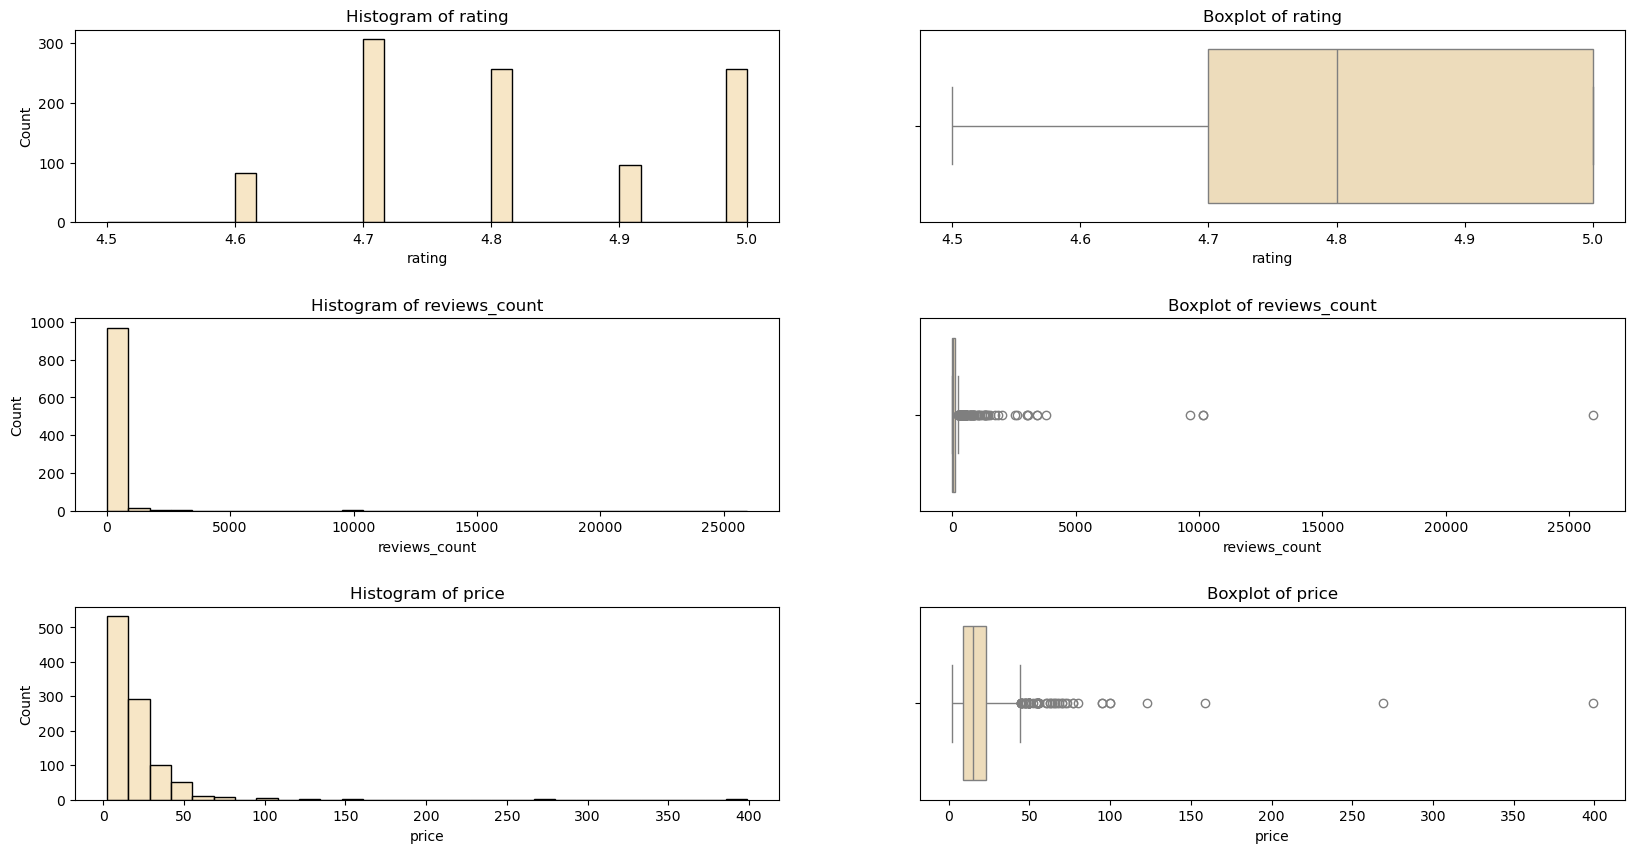

In [9]:
# 2. Distribution in numerical features

numeric_features = ['rating', 'reviews_count', 'price']

fig, axes = plt.subplots(len(numeric_features), 2, figsize=(20, 10))

for n, feat in enumerate(numeric_features):
    color = "wheat"

    # Histogram
    sns.histplot(product_df[feat], bins=30, kde=False, color=color, ax=axes[n, 0])
    axes[n, 0].set_title(f'Histogram of {feat}')

    # Boxplot
    sns.boxplot(x=product_df[feat], color=color, ax=axes[n, 1])
    axes[n, 1].set_title(f'Boxplot of {feat}')
    
plt.subplots_adjust(hspace=0.5)
plt.show()

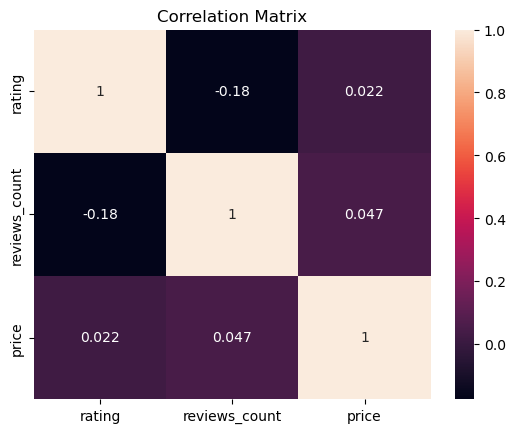

In [10]:
# 3. Correlation between numerical features (bivariate analysis)
sns.heatmap(product_df[['rating', 'reviews_count', 'price']].corr(), annot=True)
plt.title("Correlation Matrix")
plt.show()

## 2. Ingredients dataframe exploration

In [11]:
# 1. Check for data type and missing values
summary_ingredients = pd.DataFrame({
    "data_type": ingredients_df.dtypes,
    "missing_values": ingredients_df.isnull().sum()
})

summary_ingredients

,data_type,missing_values
ingredient_name,object,0
what_does,object,2
good_for,object,3
avoid,object,2
url,object,0


In [12]:
# 2. Check for duplicated data
print(f"Total number of duplicated rows: {ingredients_df.duplicated(subset=["ingredient_name"]).sum()}")

Total number of duplicated rows: 0


# 4. Data Preparation

In this section, we perform **data cleaning**, **data transformation**, and **feature engineering** to connect the ingredients list to the product catalog.

## 4.1. Data Cleaning

### (a) Product list dataset (`product_df`)
Here, we check for data duplication and perform text preprocessing to the product detail information.

In [ ]:
# 1. Define function to perform text preprocessing
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy

stop_words = set(stopwords.words('english'))

# Function to preprocess text: apply regex, remove stopwords, apply lemmatisation and lowercasing
def text_preprocessing(text, remove_stop_word=False):

    text = str(text)
    
    # a. Lowercasing
    text = text.lower()

    # b. Regex
    # Replace html and branding characters
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[®™©]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove any non-alphanumeric characters by keeping only letters, numbers, and spaces using regex
    text = re.sub(r'[^a-zA-Z0-9 ]', '', text)

    # c. (opt) Remove stopwords
    if remove_stop_word:
        # Tokenize the text
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in stop_words]
        text = " ".join(tokens)

    return text

In [ ]:
# 2. Define function to perform text preprocessing for product ingredients by finding match with `ingredients_df` as the ground truth
import pandas as pd
import re

# Function to find match between two dataframe
def find_ingredients_in_product(product_ingredients_text, ground_truth_ingredients):

    if pd.isna(product_ingredients_text):
        return []
    
    # Lowercasing
    product_text = str(product_ingredients_text).lower()
    
    # Remove unnecessary html character
    product_text = re.sub(r'\([^)]*\)', '', product_text)  
    product_text = re.sub(r'[^\w\s]', ' ', product_text)   
    product_text = re.sub(r'\s+', ' ', product_text)       

    matched_ingredients = []

    # Common words to ignore for partial matching (too generic)
    ignore_words = {'water', 'oil', 'extract', 'acid', 'butter', 'wax', 'powder', 'gel', 'cream', 'serum'}
    
    for ingredient in ground_truth_ingredients:
        ingredient_lower = ingredient.lower()
        
        match_found = False
        
        # Approach 1: Finding exact match from ground truth to product ingredients
        if ingredient_lower in product_text:
            matched_ingredients.append(ingredient_lower)
            match_found = True
        
        # Approach 2: Finding partial match
        elif not match_found:

            # Split product ingredients text into individual ingredients
            product_chunks = [chunk.strip() for chunk in re.split(r'[,\n•]', product_text) 
                            if len(chunk.strip()) > 3]
            
            for chunk in product_chunks:

                # Split ground truth and product ingredients into individual words
                ingredient_words = [w for w in ingredient_lower.split() if len(w) > 6 and w not in ignore_words]
                chunk_words = [w for w in chunk.split() if len(w) > 6 and w not in ignore_words]
                
                # Only proceed if both have meaningful words after filtering
                if not ingredient_words or not chunk_words:
                    continue
                
                # Finding partial match in two direction from ground truth to product ingredients, and the other way around
                for ing_word in ingredient_words:
                    for chunk_word in chunk_words:
                        
                        if (ing_word in chunk_word) or (chunk_word in ing_word):
                            matched_ingredients.append(ingredient_lower)
                            match_found = True
                            break

                    if match_found:
                        break
                
                if match_found:
                    break
    
    return matched_ingredients

# Function to perform looping for the entire product list
def ingredients_preprocessing(product_df, ingredients_df):

    ground_truth_ingredients = ingredients_df['ingredient_name'].tolist()
    
    results = []
    
    for _, row in product_df.iterrows():
        
        # Find matching ingredients
        matched_ingredients = find_ingredients_in_product(row['ingredients'], ground_truth_ingredients)
        
        results.append({
            'ingredients_clean': matched_ingredients,
            'num_ingredients': len(matched_ingredients)
        })

    product_df['ingredients_clean'] = [x['ingredients_clean'] for x in results]
    product_df['num_ingredients'] = [x['num_ingredients'] for x in results]

    return product_df


In [ ]:
sample = 'Aqua, Niacinamide (Vitamin B3), Sodium Hyaluronate, Tocopherol (Vit E), Butylene Glycol, Phenoxyethanol, 
Retinyl Palmitate (Vitamin A), Fragrance
ground_truth_ingredients = ingredients_df['ingredient_name'].tolist()

find_ingredients_in_product(sample, ground_truth_ingredients)

['ascorbyl palmitate',
 'heptapeptide-15 palmitate',
 'niacinamide',
 'retinyl palmitate',
 'retinyl propionate',
 'retinyl retinoate']

In [15]:
# Apply pre-processing to each text features
product_df['name'] = product_df['name'].apply(lambda x: text_preprocessing(x))
product_df['general_information'] = product_df['general_information'].apply(lambda x: text_preprocessing(x))
product_df = ingredients_preprocessing(product_df, ingredients_df)

In [16]:
# Apply pre-processing to numerical feature
product_df['price'] = product_df['price'].apply(lambda x: float(str(x).replace('$', '')) if isinstance(x, str) else float(x))

In [17]:
# Preview product_df after cleaning
product_df[['name', 'general_information', 'ingredients_clean']].head(3)

,name,general_information,ingredients_clean
0,palmers shea butter body oil 250ml,palmers shea formula body oil soothes and nour...,"[acetylarginyltryptophyl diphenylglycine, dipe..."
1,la roche posay cicaplast baume b5 100ml,multirepairing hydrating balm for dry skin cic...,"[acetylarginyltryptophyl diphenylglycine, alph..."
2,avene thermal spring water 300ml mist for sen...,the unique and constant composition of avne th...,[avene thermal water]


### (b) Ingredient list dataset (`ingredients_df`)

Similarly, we also check for data duplication and perform text preprocessing to the ingredients information.

In [18]:
# 1. Define function to perform pre-processing for ingredients dataset for benefit and allergies column
def benefit_allergies_preprocessing(ingredients_text):

    text = str(ingredients_text)

    # Lowercase
    text = text.lower()

    # Remove unnecessary character
    text = re.sub(r'\n:', '', text).strip()
    text = re.sub(r'\n', ',', text)

    # Split into list
    text_list = text.split(",")

    return text_list

In [19]:
# Apply pre-processing to each text features
ingredients_df['ingredient_name'] = ingredients_df['ingredient_name'].apply(lambda x: text_preprocessing(x))
ingredients_df['what_does'] = ingredients_df['what_does'].apply(lambda x: text_preprocessing(x))
ingredients_df['good_for'] = ingredients_df['good_for'].apply(lambda x: benefit_allergies_preprocessing(x))
ingredients_df['avoid'] = ingredients_df['avoid'].apply(lambda x: benefit_allergies_preprocessing(x))

In [20]:
# Preview product_df after cleaning
ingredients_df[['ingredient_name', 'good_for', 'avoid']].head(3)

,ingredient_name,good_for,avoid
0,acai extract,[pregnancy],"[acai extract, related allergy]"
1,acetylarginyltryptophyl diphenylglycine,"[elasticity, fine lines, pregnancy, wrinkles]","[acetylarginyltryptophyl diphenylglycine, rela..."
2,acetyl glucosamine,"[dry and dehydrated skin, elasticity, fine lin...","[acetyl glucosamine, related allergy]"


## 4.2. Data Transformation
Continuing, in here, we perform scaling to the numerical variables using MinMaxScaler and encoding to the categorical variables.

In [21]:
import pandas as pd

# 1. Create function to perform scaling for numerical features
def min_max_scale(df, numeric_cols):

    df_scaled = df.copy()
    for col in numeric_cols:
        min_val = df[col].min()
        max_val = df[col].max()

        df_scaled[col] = (df[col] - min_val) / (max_val - min_val)
    return df_scaled


In [22]:
# Implement scaling to numerical features
product_df_scaled = min_max_scale(product_df, numeric_features)
product_df_scaled.describe()

,price,rating,reviews_count,num_ingredients
count,1000.000000,1000.00000,1000.000000,1000.000000
mean,0.042813,0.62720,0.007003,7.304000
std,0.052462,0.26467,0.040000,7.093652
min,0.000000,0.00000,0.000000,0.000000
25%,0.017072,0.40000,0.000193,2.000000
50%,0.032001,0.60000,0.001040,6.000000
75%,0.052537,1.00000,0.003891,10.000000
max,1.000000,1.00000,1.000000,46.000000


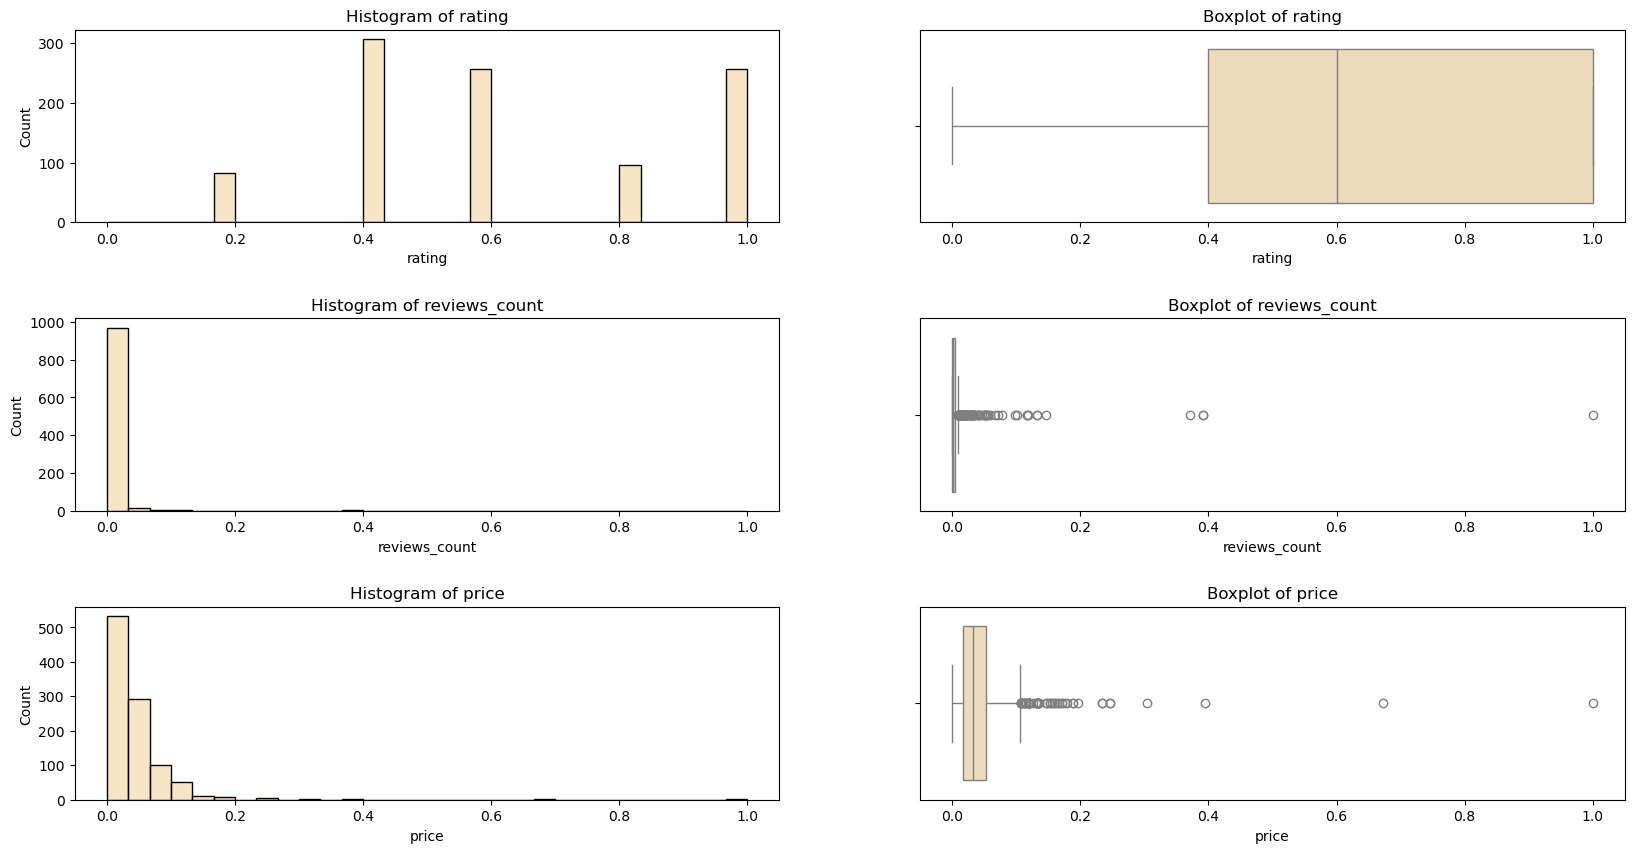

In [23]:
# 2. Distribution in numerical features

numeric_features = ['rating', 'reviews_count', 'price']

fig, axes = plt.subplots(len(numeric_features), 2, figsize=(20, 10))

for n, feat in enumerate(numeric_features):
    color = "wheat"

    # Histogram
    sns.histplot(product_df_scaled[feat], bins=30, kde=False, color=color, ax=axes[n, 0])
    axes[n, 0].set_title(f'Histogram of {feat}')

    # Boxplot
    sns.boxplot(x=product_df_scaled[feat], color=color, ax=axes[n, 1])
    axes[n, 1].set_title(f'Boxplot of {feat}')
    
plt.subplots_adjust(hspace=0.5)
plt.show()

## 4.3. Feature Engineering

### (a) Benefit and Allergies

In [24]:
# 1. Enrich `product_df` by taking the benefit and allergies from `ingredients_df` lookup from the ingredient list that already pre-processed to ensure alignment between the two dataframe


# Map the benefit to skin concern to standardise user input
concern_mapping = {
    'pregnancy': 'pregnancy',
    'radiance': 'dull skin',
    'texture': 'texture',
    'dark circles': 'pigmentation',
    'eye bags': 'pigmentation',
    'impaired skin barrier': 'impaired skin barrier',
    'redness': 'redness',
    'fine lines': 'wrinkles',
    'wrinkles': 'wrinkles',
    'blackheads': 'pores',
    'acne': 'acne',
    'elasticity': 'impaired skin barrier',
    'pigmentation': 'pigmentation',
    'enlarged pores': 'pores',
    'post blemish marks': 'pigmentation',
    'uv protection': 'uv protection',
    
    'oily': 'oily',
    'dry and dehydrated skin': 'dry',
    'combination': 'combination',
    'anyone': 'normal'
}

# Map the allergies to reduced and standardise to user input
allergies_mapping = {
    'pregnancy': 'pregnancy',
    'impaired skin barrier': 'impaired skin barrier',
    'gluten allery': 'gluten allery',
    'vegan': 'vegan',

    'oily': 'oily',
    'dry dehydrated': 'dry',
    'combination': 'combination',
    'sensitive': 'sensitive'

}

# Create function to perform the lookup
def lookup_benefit_ingredients(product_df, ingredients_df):
    
    # Create dictionaries for lookup
    good_for_map = dict(zip(ingredients_df['ingredient_name'], ingredients_df['good_for']))
    avoid_map    = dict(zip(ingredients_df['ingredient_name'], ingredients_df['avoid']))

    all_good_for = []
    all_avoid = []

    for _, row in product_df.iterrows():
        good_for_set = set()
        avoid_set = set()

        for ingredient in row['ingredients_clean']:
            
            if ingredient in avoid_map:
                val = avoid_map[ingredient]
                if val:
                    # Standardize and compile 'avoid' items
                    avoid_set.update([allergies_mapping[v] for v in val if v in allergies_mapping and v != 'nan'])


            if ingredient in good_for_map:
                val = good_for_map[ingredient]
                if val: 
                    # Standardize and compile 'good_for' items
                    good_for_set.update([concern_mapping.get(v, v) for v in val if v != 'nan'])

            # Exclude benefits that also appear in avoid (due to different ingredients that cause overlapping details and we prioritize avoid as it is more sensitive)
            filtered_good_for = good_for_set - avoid_set

        all_good_for.append(list(filtered_good_for))
        all_avoid.append(list(avoid_set))
    
    product_df['benefit'] = all_good_for
    product_df['avoid'] = all_avoid

    return product_df


In [25]:
# Implement the lookup between product ingredient to the benefit and allergies (avoid)
product_df = lookup_benefit_ingredients(product_df, ingredients_df)
product_df[['name', 'ingredients', 'ingredients_clean', 'benefit', 'avoid']].head()

,name,ingredients,ingredients_clean,benefit,avoid
0,palmers shea butter body oil 250ml,"Glycine Soja (Soybean) Oil, Isopropyl Myristat...","[acetylarginyltryptophyl diphenylglycine, dipe...","[dull skin, pores, pigmentation, acne, texture...","[pregnancy, sensitive, oily, dry, impaired ski..."
1,la roche posay cicaplast baume b5 100ml,AQUA / WATER / EAU • HYDROGENATED POLYISOBUTE...,"[acetylarginyltryptophyl diphenylglycine, alph...","[dull skin, pregnancy, pores, acne, dry, textu...","[impaired skin barrier, combination, oily]"
2,avene thermal spring water 300ml mist for sen...,AVENE THERMAL SPRING WATER (AVENE AQUA). GAS :...,[avene thermal water],"[dry, texture, dull skin, impaired skin barrie...",[]
3,palmers shimmer radiance body oil 150ml,"Mineral Oil (Paraffinum Liquidum), Isopropyl P...","[ascorbyl palmitate, heptapeptide-15 palmitate...","[dull skin, pores, pigmentation, acne, texture...","[pregnancy, sensitive, dry, impaired skin barr..."
4,cerave moisturising cream 454g,2021500 - INGREDIENTS: AQUA / WATER • GLYCERI...,"[caprooyl phytosphingosine, caprooyl sphingosi...","[dull skin, pores, pigmentation, acne, texture...","[pregnancy, sensitive, gluten allery, impaired..."


### (b) Product type

In [26]:
import re
from collections import Counter
from sentence_transformers import SentenceTransformer, util
import torch

# Load sentence transformer model for fuzzy matching
model = SentenceTransformer('all-MiniLM-L6-v2')

def classify_product(text, classify_dict, rule_weight=0.7, fuzzy_weight=0.3, threshold=0.2):

    # Concat key and values from mapping to enrich embedding
    concat_key_values = []
    max_hits_dict = {}
    for key, keywords in classify_dict.items():
        combined_text = key + ' ' + ' '.join(keywords)
        concat_key_values.append(combined_text)
        max_hits_dict[key] = len(keywords)

    classify_dict_keys = list(classify_dict.keys())
    classify_dict_embeddings = model.encode(concat_key_values, convert_to_tensor=True)
    text_lower = text.lower() if isinstance(text, str) else ''
    
    # Approach 1: Finding exact match
    rule_scores = Counter()
    for product_type, keywords in classify_dict.items():
        hits = sum(bool(re.search(r'\b' + re.escape(x.lower()) + r'\b', text_lower)) for x in keywords)
        max_hits = max_hits_dict[product_type]

        # Normalize the score
        rule_scores[product_type] = hits / max_hits if max_hits > 0 else 0
    

    # Approach 2: Finding partial match with text embedding
    text_embedding = model.encode(text_lower, convert_to_tensor=True)
    cos_sim = util.cos_sim(text_embedding, classify_dict_embeddings).squeeze() 
    fuzzy_scores = {classify_dict_keys[i]: cos_sim[i].item() for i in range(len(classify_dict_keys))}
    
    # Combine scores from both approach
    combined_scores = {x: rule_weight * rule_scores.get(x, 0) + fuzzy_weight * fuzzy_scores.get(x, 0)
                       for x in classify_dict.keys()}
    
    # Choose result with the highest score
    best_type = max(combined_scores, key=combined_scores.get)

     # Check confidence
    best_type = max(combined_scores, key=combined_scores.get)
    if combined_scores[best_type] < threshold:
        return "other"
    else:
        return best_type


In [27]:
# Create product types dictionary with its keywords
product_types = {
    'cleanser': ['cleanser', 'face wash', 'cleansing'],
    'toner': ['toner', 'facial toner', 'hydrating toner'],
    'facial mist': ['mist', 'face mist'],
    'serum': ['serum', 'concentrate', 'ampoule'],
    'moisturizer': ['moisturizer', 'cream', 'lotion'],
    'sunscreen': ['sunscreen', 'spf', 'sun protection'],
    'face mask': ['mask', 'sheet mask', 'clay mask'],
    'exfoliator': ['exfoliator', 'scrub', 'peel'],
    'eye cream': ['eye cream', 'eye gel', 'eye treatment'],
    'chemical peel': ['chemical peel', 'peeling solution'],
    'lip care': ['lip', 'lip balm', 'lip treatment'],
    'acne treatment': ['acne', 'pimple', 'blemish'],
    'hyperpigmentation treatment': ['hyperpigmentation', 'uneven', 'dark spot'],
    'anti-aging': ['fine lines', 'wrinkles', 'anti-aging'],
    'face oil': ['face oil', 'facial oil']
}

In [28]:
# Classify each product by type
product_df['concat_name_description'] = product_df['name'].fillna('') + ' ' + product_df['general_information'].fillna('')
product_df['product_type'] = product_df['concat_name_description'].apply(lambda x: classify_product(x, product_types))
product_df[['name', 'product_type']].head()

,name,product_type
0,palmers shea butter body oil 250ml,other
1,la roche posay cicaplast baume b5 100ml,lip care
2,avene thermal spring water 300ml mist for sen...,facial mist
3,palmers shimmer radiance body oil 150ml,other
4,cerave moisturising cream 454g,moisturizer


### (c) Product formulation

In [29]:
# Create product formulation dictionary with its keywords
product_formulation = {
    'water': ['water', 'aqua', 'toner', 'spray', 'essence', 'mist', 'serum'],
    'oil': ['oil', 'facial oil', 'plant oil', 'jojoba', 'argan'],
    'cream': ['cream', 'lotion', 'moisturise', 'milk', 'gel'],
    'solid': ['solid', 'stick', 'soap', 'bar', 'wax'],
    'balm': ['balm', 'ointment', 'lip balm'],
    'foam': ['foam', 'foaming', 'mousse', 'lather'],
    'mask/patch/wipes': ['face mask', 'sheet mask', 'mask', 'patch', 'acne patch', 'wipes']
}

In [31]:
# Classify each product by formulation
product_df['formulation'] = product_df['concat_name_description'].apply(lambda x: classify_product(x, product_formulation))
product_df[['name', 'formulation']].head()

,name,formulation
0,palmers shea butter body oil 250ml,oil
1,la roche posay cicaplast baume b5 100ml,balm
2,avene thermal spring water 300ml mist for sen...,water
3,palmers shimmer radiance body oil 150ml,oil
4,cerave moisturising cream 454g,cream


In [34]:
# Re-apply scaling to the transformed dataset
for col in numeric_features:
    product_df[col+"_raw"] = product_df[col].copy()

product_df = min_max_scale(product_df, numeric_features)

# Select essential columns for concise modeling dataset
product_df = product_df[['name', 'price', 'rating', 'reviews_count', 'price_raw', 'rating_raw', 'reviews_count_raw', 'general_information', 'ingredients_clean',
                        'benefit', 'avoid','product_type', 'formulation', 'url', 'img_url']].copy()

# Rename column for clean naming
product_df = product_df.rename(columns={"ingredients_clean":"ingredients"})

In [36]:
# Save the clean data
product_df.to_csv('products_list_clean.csv', index=False)
ingredients_df.to_csv('ingredients_list_clean.csv', index=False)

# 5. EDA: After Data Preparation

We perform another exploration using the cleaned dataset to obtain more relevant information about the products separation.

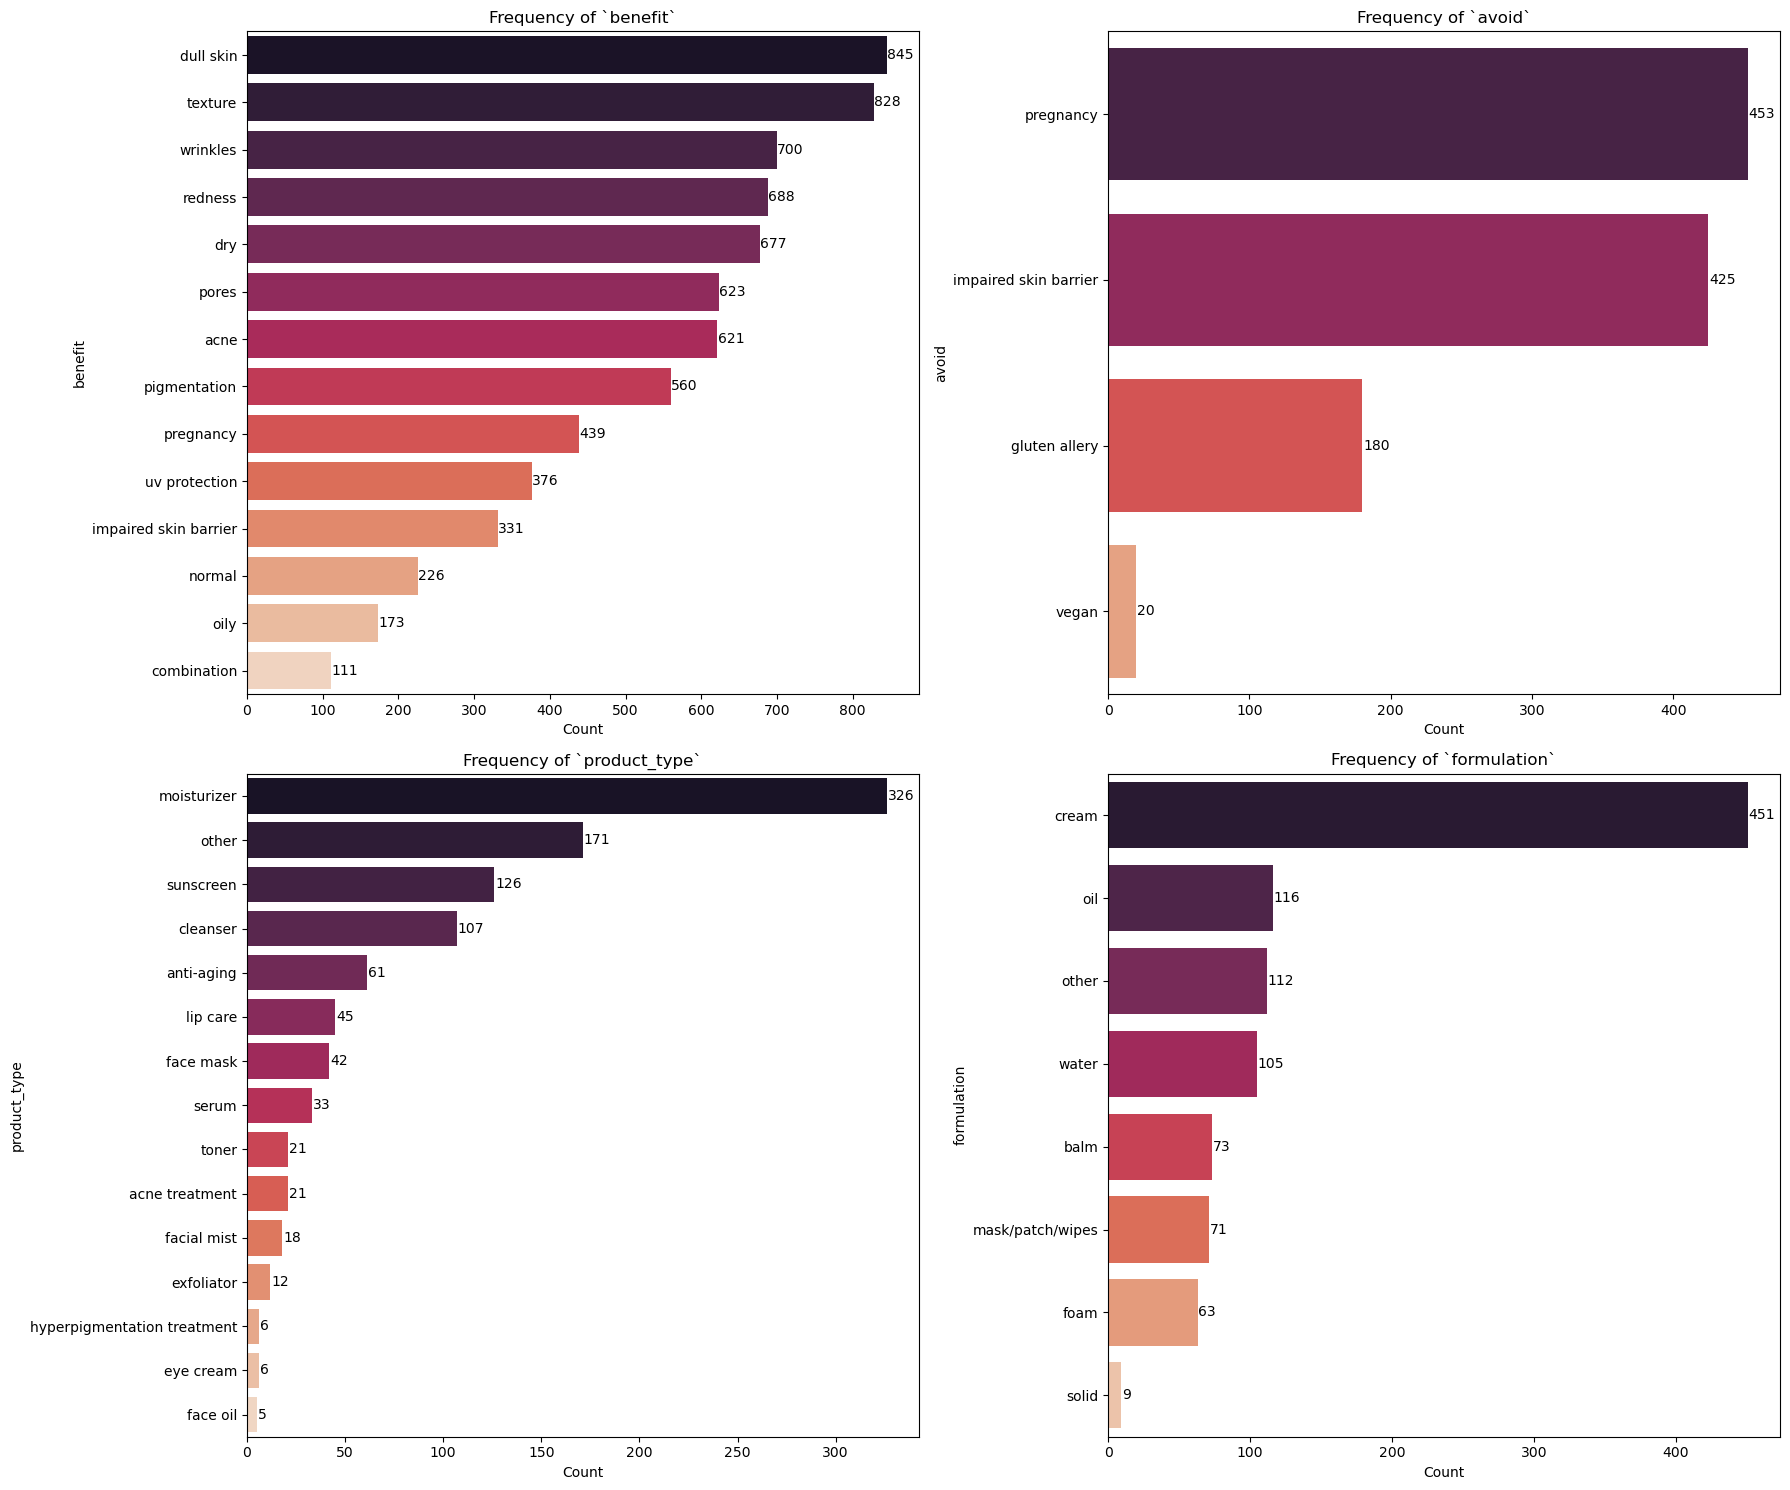

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

categorical_features = ['benefit', 'avoid', 'product_type', 'formulation']

fig, axes = plt.subplots(2, 2, figsize=(18, 15))  
axes = axes.flatten()

for i, feat in enumerate(categorical_features):
    ax = axes[i]  
    
    all_values = product_df[feat].explode()

    if feat == 'avoid':
        to_remove = ['oily', 'dry', 'sensitive', 'combination']
        all_values = all_values[~all_values.isin(to_remove)]

    top_values = all_values.value_counts()

    col_palette = sns.color_palette("rocket", n_colors=len(top_values))

    sns.barplot(
        x=top_values.values,
        y=top_values.index,
        hue=top_values.index,
        ax=ax,
        palette=col_palette
    )

    # Add count labels 
    for j, (value, name) in enumerate(zip(top_values.values, top_values.index)):
        ax.text(value + 0.5, j, str(value), va='center')


        
    ax.set_title(f"Frequency of `{feat}`")
    ax.set_xlabel("Count")
    ax.set_ylabel(f"{feat}")


plt.tight_layout()
plt.show()


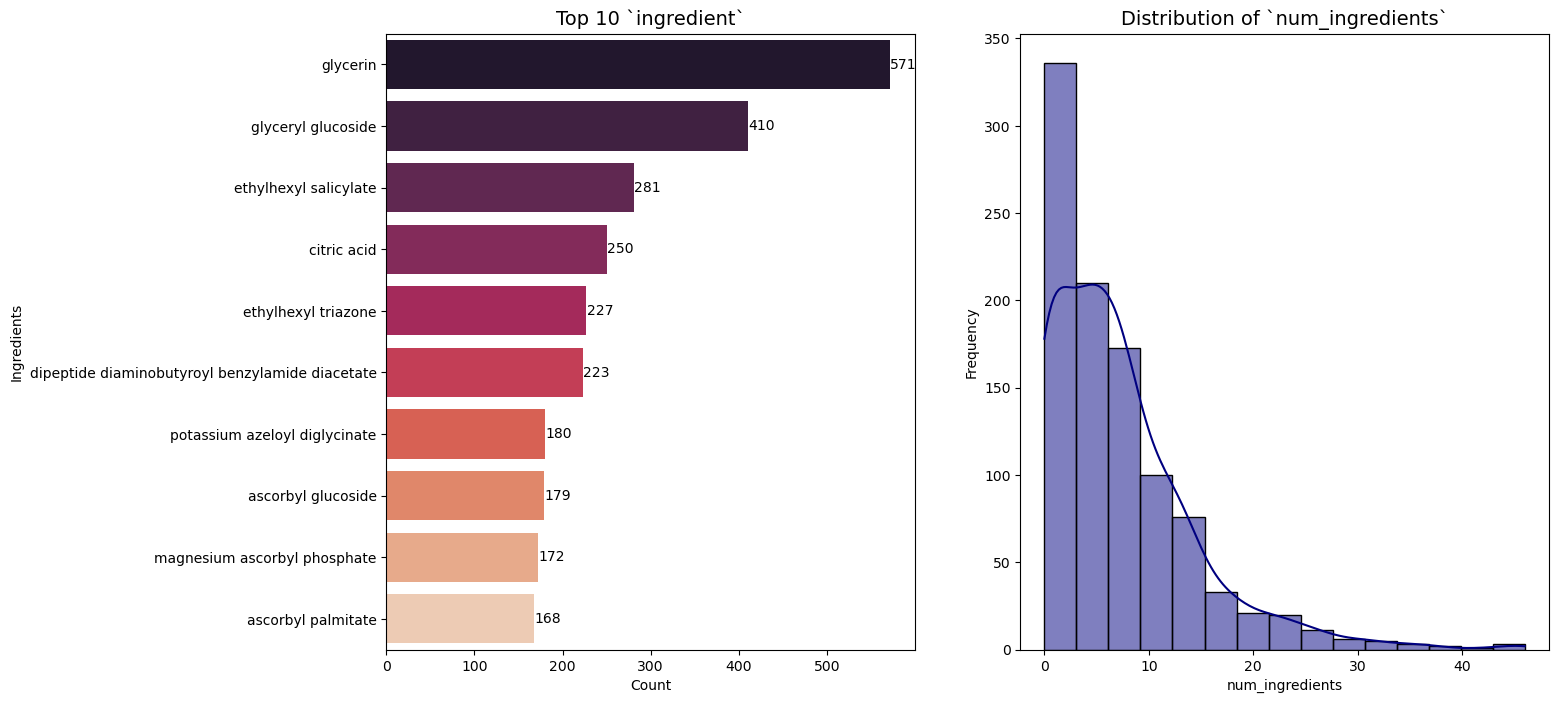

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(15, 8))
plt.subplots_adjust(hspace=0.4)

# Count number of ingredients per row
product_df['num_ingredients'] = product_df['ingredients'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Bar plot
all_values = product_df['ingredients'].explode()
top_values = all_values.value_counts().head(10)

# Brown gradient palette
col_palette = sns.color_palette("rocket", n_colors=len(top_values))

sns.barplot(
    x=top_values.values,
    y=top_values.index,
    hue=top_values.index,
    ax=axes[0],
    palette=col_palette
)

# Add count labels
for j, (value, name) in enumerate(zip(top_values.values, top_values.index)):
    axes[0].text(value + 0.5, j, str(value), va='center')

axes[0].set_title(f"Top 10 `ingredient`", fontsize=14)
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Ingredients")

# Histogram
sns.histplot(product_df['num_ingredients'].dropna(), kde=True, ax=axes[1], color='navy', bins=15)
axes[1].set_title(rf"Distribution of `num_ingredients`", fontsize=14)
axes[1].set_xlabel("num_ingredients")
axes[1].set_ylabel("Frequency")

plt.show()


/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


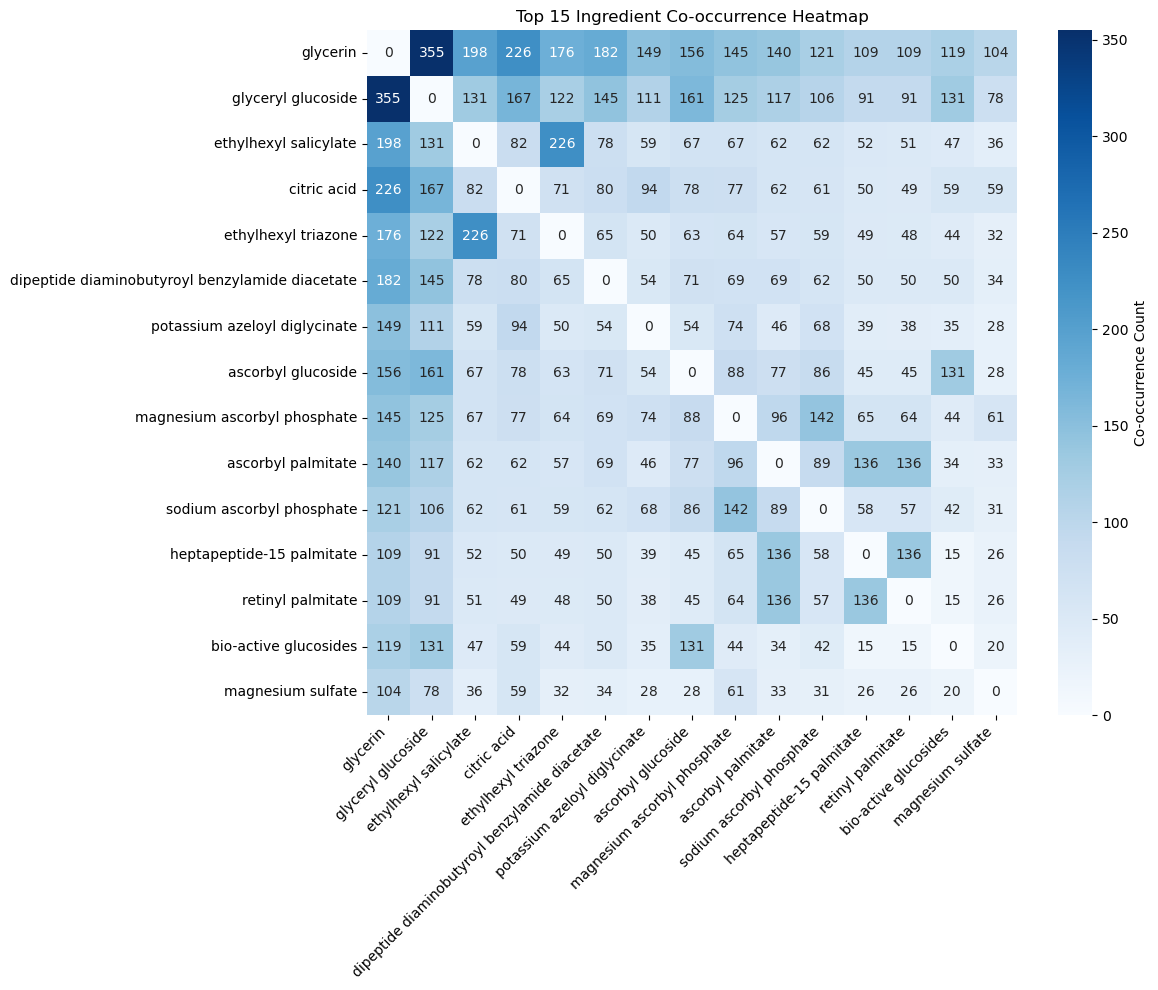

In [45]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# Convert list of ingredients to space-separated strings
ingredient_strings = product_df['ingredients'].apply(lambda x: ";".join(x))

# Vectorize
vectorizer = CountVectorizer(
    tokenizer=lambda x: [tok for tok in x.split(";") if tok.strip() != ""],
    binary=True
)

X = vectorizer.fit_transform(ingredient_strings)

# Co-occurrence matrix
cooc_matrix = (X.T @ X).toarray()
np.fill_diagonal(cooc_matrix, 0)

# Get top N ingredients by frequency
ingredient_counts = X.sum(axis=0).A1
top_n = 15
top_indices = ingredient_counts.argsort()[::-1][:top_n]
top_ingredients = [vectorizer.get_feature_names_out()[i] for i in top_indices]

# Subset co-occurrence matrix
top_matrix = cooc_matrix[np.ix_(top_indices, top_indices)]

# Plot heatmap
plt.figure(figsize=(12,10))
sns.heatmap(top_matrix, 
            xticklabels=top_ingredients, 
            yticklabels=top_ingredients, 
            cmap="Blues", 
            annot=True, 
            fmt="d",
            cbar_kws={'label': 'Co-occurrence Count'})
plt.title(f"Top {top_n} Ingredient Co-occurrence Heatmap")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


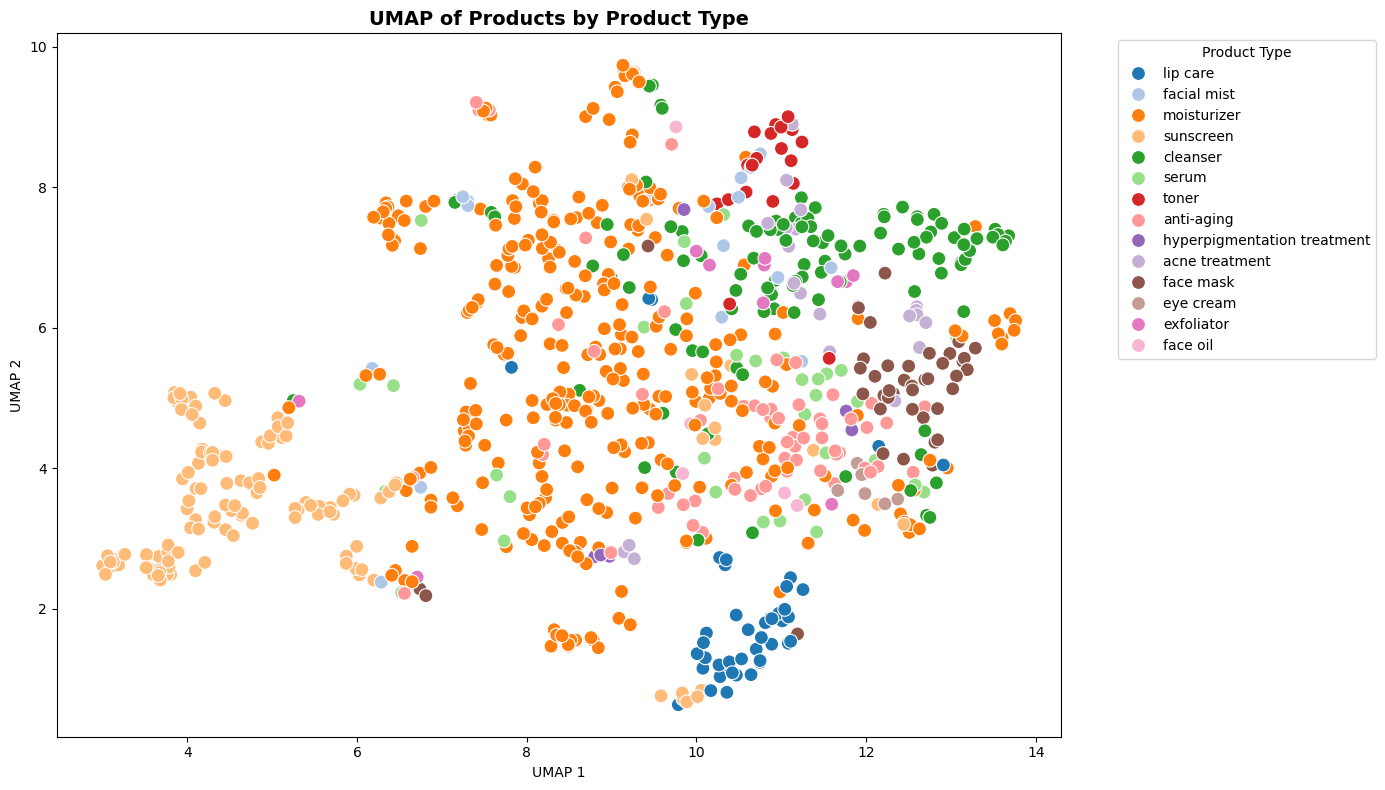

In [50]:
from sentence_transformers import SentenceTransformer
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# Exclude products with 'other' type
product_df_filtered = product_df[product_df['product_type'] != 'other'].reset_index(drop=True)
product_df_filtered['concat_name_description'] = product_df_filtered['name'] + product_df_filtered['general_information']

# Generate embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(product_df_filtered['concat_name_description'].tolist(), normalize_embeddings=True)

# Reduce dimensionality
reducer = umap.UMAP(n_neighbors=15, min_dist=0.3, random_state=42)
emb_2d = reducer.fit_transform(embeddings)

# Plot by product type
plt.figure(figsize=(14,8))
sns.scatterplot(
    x=emb_2d[:,0],
    y=emb_2d[:,1],
    hue=product_df_filtered['product_type'],
    palette=sns.color_palette("tab20", 14),
    s=100
)
plt.title("UMAP of Products by Product Type", fontsize=14, fontweight='bold')
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(
    title="Product Type",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)
plt.tight_layout()
plt.show()


# 6. Modeling and Experiment

We begin modeling using the three-stage hybrid recommendation system. The process flow in this structure:
1. **Constraint-based filtering** to filter product candidates that fulfill the hard and soft constraints.
2. **Semantic ranking** using bi-encoder or cross-encoder to filter the top 100 candidates based on similarity score.
3. **Neural network quality assessment** to re-rank products by combining the quality score with the semantic similarity score from the previous step, resulting in the final top 5 product or top 5 routines.

In [1]:
# Load clean data set
import pandas as pd

clean_product_df = pd.read_csv('products_list_clean.csv')
clean_product_df.iloc[:,:-2].head()

,name,price,rating,reviews_count,price_raw,rating_raw,reviews_count_raw,general_information,ingredients,benefit,avoid,product_type,formulation
0,palmers shea butter body oil 250ml,0.012221,1.0,0.000154,6.99,5.0,5,palmers shea formula body oil soothes and nour...,"['acetylarginyltryptophyl diphenylglycine', 'd...","['dull skin', 'pores', 'pigmentation', 'acne',...","['pregnancy', 'sensitive', 'oily', 'dry', 'imp...",other,oil
1,la roche posay cicaplast baume b5 100ml,0.087814,0.4,0.020918,36.99,4.7,544,multirepairing hydrating balm for dry skin cic...,"['acetylarginyltryptophyl diphenylglycine', 'a...","['dull skin', 'pregnancy', 'pores', 'acne', 'd...","['impaired skin barrier', 'combination', 'oily']",lip care,balm
2,avene thermal spring water 300ml mist for sen...,0.024820,0.6,0.028585,11.99,4.8,743,the unique and constant composition of avne th...,['avene thermal water'],"['dry', 'texture', 'dull skin', 'impaired skin...",[],facial mist,water
3,palmers shimmer radiance body oil 150ml,0.019780,0.8,0.000231,9.99,4.9,7,palmers cocoa butter formula shimmer radiance ...,"['ascorbyl palmitate', 'heptapeptide-15 palmit...","['dull skin', 'pores', 'pigmentation', 'acne',...","['pregnancy', 'sensitive', 'dry', 'impaired sk...",other,oil
4,cerave moisturising cream 454g,0.060097,0.4,0.059481,25.99,4.7,1545,rich cream for dry to very dry skin rich ceram...,"['caprooyl phytosphingosine', 'caprooyl sphing...","['dull skin', 'pores', 'pigmentation', 'acne',...","['pregnancy', 'sensitive', 'gluten allery', 'i...",moisturizer,cream


In [2]:
import pandas as pd
import torch
import numpy as np
import random
from tqdm import tqdm
import ast
from itertools import product as itertools_product
from sentence_transformers import SentenceTransformer, util, CrossEncoder
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, MultiLabelBinarizer
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

### Define Recommendation System Architecture
### Consist of three main steps: bi-encoder semantic similarity, constaints-based filtering, and neural network re-ranking

class HybridRecommendationSystem:

    ### 0. Define constructor to load text encoders
    def __init__(self):
        
        # Set device
        self.device = "mps" if torch.backends.mps.is_available() else "cpu"
        print(f"Device: {self.device}")

        # Load cross-encoder and bi-encoder for semantic search
        self.cross_encoder = CrossEncoder('cross-encoder/ms-marco-TinyBERT-L-2-v2', device=self.device)
        self.bi_encoder = SentenceTransformer('paraphrase-MiniLM-L3-v2', device=self.device)
        
        # Load text encoder for neural network
        self.text_encoder = SentenceTransformer('paraphrase-MiniLM-L3-v2', device=self.device)
        
        # Preprocessing components
        self.scalers = {}
        self.encoders = {}
        self.mlb_encoders = {}
        self.feature_names = []
        self.neural_model = None
    
    ### 1. Create dictionary of user profile
    def create_user_profile(self, skin_type, skin_problems, allergies, preferred_formulation, budget, product_types):

        return {
            'skin_type': skin_type,
            'skin_problems': skin_problems,
            'allergies': allergies,
            'preferred_formulation': preferred_formulation,
            'budget': budget,
            'product_types': product_types      # can be a string (for single product recommendation) or a list (for routine recommendation)
        }
    
    ### 2. Concatenated user profile details into a single text for embedding
    def build_user_text(self, profile):

        parts = []
        
        if profile.get('skin_type'):
            parts.append(f"Skin type: {profile['skin_type']}")
        
        if profile.get('skin_problems'): 
            parts.append(f"Skin problems: {profile['skin_problems']}")
        
        if profile.get('product_types'): 
            types = profile['product_types'] if isinstance(profile['product_types'], list) else [profile['product_types']]
            parts.append(f"Product type: {', '.join(types)}")
        
        if profile.get('preferred_formulation'):
            parts.append(f"Formulation: {profile['preferred_formulation']}")
        
        return ". ".join(parts)
    
    ### 3. Concatenated product details into a single text for embedding (x_embedding)
    def build_product_texts(self, product_df):

        texts = []
        for _, row in product_df.iterrows():
            parts = []

            name = row.get('name')
            if name is not None and pd.notna(name): 
                parts.append(f"Product: {name}")

            benefit = row.get('benefit')
            if benefit is not None and isinstance(benefit, list):
                if len(benefit) > 0: 
                    benefit_str = ', '.join(str(b) for b in benefit)
                    parts.append(f"Benefits: {benefit_str}")
            
            product_type = row.get('product_type')
            if product_type is not None and pd.notna(product_type):
                parts.append(f"Product type: {product_type}")

            formulation = row.get('formulation')
            if formulation is not None and pd.notna(formulation):
                parts.append(f"Formulation: {formulation}")

            general_info = row.get('general_information')
            if general_info is not None and pd.notna(general_info):
                parts.append(f"Product information: {general_info}")
            
            texts.append(". ".join(parts))
        
        return texts

    ### 4. Fit and transform each product detais into a vector of structured features for neural network (x_structured)
    def fit_transform_features(self, product_df):
        features, feature_names = [], []
        
        # Numerical features
        for col in ['price_raw', 'rating_raw', 'reviews_count_raw']:
            if col in product_df.columns:
                scaler = MinMaxScaler()
                values = product_df[col].fillna(0).values.reshape(-1, 1)
                features.append(scaler.fit_transform(values))
                feature_names.append(f"{col}_scaled")

                self.scalers[col] = scaler
        
        # Categorical features
        for col in ['product_type', 'formulation']:
            if col in product_df.columns:
                le = LabelEncoder()
                values = product_df[col].fillna("unknown")
                features.append(le.fit_transform(values).reshape(-1,1).astype(float))
                feature_names.append(f"{col}_encoded")

                self.encoders[col] = le
        
        # Multi-label features
        for col in ['benefit', 'avoid']:
            if col in product_df.columns:
                # processed_data = self.process_text_lists(product_df[col])
                mlb = MultiLabelBinarizer()
                encoded = mlb.fit_transform(product_df[col])
            
                features.append(encoded.astype(float))
                feature_names.extend([f"{col}_{cls}" for cls in mlb.classes_])

                self.mlb_encoders[col] = mlb
        
        self.feature_names = feature_names
        X = np.hstack(features) if features else np.array([]).reshape(len(product_df), 0)
        
        return X
    
    ### 5. Transform each product detais using fitted scaler and encoder (x_structured)
    def transform_features(self, product_df):
        features = []
        
        # Numerical features
        for col in ['price_raw', 'rating_raw', 'reviews_count_raw']:
            if col in product_df.columns and col in self.scalers:
                values = product_df[col].fillna(0).values.reshape(-1, 1)
                features.append(self.scalers[col].transform(values))
        
        # Categorical features
        for col in ['product_type', 'formulation']:
            if col in product_df.columns and col in self.encoders:
                values = product_df[col].fillna("unknown")
                features.append(self.encoders[col].transform(values).reshape(-1,1).astype(float))
        
        # Multi-label features
        for col in ['benefit', 'avoid']:
            if col in product_df.columns and col in self.mlb_encoders:
                encoded = self.mlb_encoders[col].transform(product_df[col])
                features.append(encoded.astype(float))
        
        X = np.hstack(features) if features else np.array([]).reshape(len(product_df), 0)

        return X
        
    ### 6. Apply constraint-based filtering
    def apply_hard_constraints(self, product_df, profile, candidate_indices=None):

        # Get product types from profile
        product_types = profile.get('product_types', [])
        if not isinstance(product_types, list):
            product_types = [product_types]
        
        # Initialize result dictionary
        filtered_by_type = {}
        
        for product_type in product_types:
            
            if candidate_indices is not None:
                filtered = product_df.iloc[candidate_indices].copy()
            else:
                filtered = product_df.copy()
            
            # a. Filter product types based on user request (strict constraint)
            filtered = filtered[filtered["product_type"].str.lower() == product_type.lower()]
            
            # b. Filter product that contains user allergies (strict constraint)
            if profile.get("allergies"):
                # Parse user allergies once
                user_allergies = set(a.strip().lower() for a in profile["allergies"].split(",") if a.strip())

                def has_allergen(avoid_list):
                    avoid_list = ast.literal_eval(avoid_list)
                    product_allergies = set(avoid_list)

                    return len(user_allergies & product_allergies) > 0 

                # Keep only products without allergens
                mask = ~filtered["avoid"].apply(has_allergen)
                filtered = filtered[mask]
                
            # c. Filter product formulation based on user request (soft constraint)
            if profile.get("preferred_formulation"):
                backup_filtered = filtered.copy()
                formulation = profile["preferred_formulation"]
                forms = [formulation.lower()]
                filtered_form = filtered[filtered["formulation"].str.lower().isin(forms)]
                
                # If too restrictive, skip this filter
                if len(filtered_form) >= 5:
                    filtered = filtered_form
                else:
                    filtered = backup_filtered

            # d. Filter product with price above user budget (soft constraint)
            if profile.get('budget') is not None:
                backup_filtered = filtered.copy()
                
                # For single product -> use full budget
                # For routine -> use weighted allocation
                if len(product_types) == 1:
                    type_budget = profile['budget']
                else:
                    weight = BUDGET_WEIGHTS.get(product_type.lower(), 1.0 / len(product_types))
                    type_budget = profile['budget'] * weight * 1.5  # 1.5x buffer for flexibility
                
                filtered_budget = filtered[filtered["price_raw"] <= type_budget]
                
                # If too restrictive, skip this filter
                if len(filtered_budget) >=5 :
                    filtered = filtered_budget
                else:
                    filtered = backup_filtered
            
            # Sort by price
            filtered = filtered.sort_values('price_raw', ascending=True)
            
            # Store indices for this product type
            filtered_by_type[product_type] = filtered.index.tolist()
        
        return filtered_by_type

    ### 7. The architecture of the neural network to assess quality
    def build_neural_network_predictor(self, structured_dim, embedding_dim, dropout_rate=0.3):

        # Inputs
        structured_input = layers.Input(shape=(structured_dim,), name='structured_input')
        embedding_input = layers.Input(shape=(embedding_dim,), name='embedding_input')
        
        # Structured features branch
        s = layers.Dense(128, activation='relu')(structured_input)
        s = layers.BatchNormalization()(s)
        s = layers.Dropout(dropout_rate)(s)
        
        # Text embedding branch
        e = layers.Dense(128, activation='relu')(embedding_input)
        e = layers.BatchNormalization()(e)
        e = layers.Dropout(dropout_rate)(e)
        
        # Combine all branches
        combined = layers.Concatenate()([s, e])
        
        # Hidden layers
        x = layers.Dense(256, activation='relu')(combined)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)
        
        x = layers.Dense(128, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate/2)(x)
        
        x = layers.Dense(64, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        
        # Output layer
        output = layers.Dense(1, activation='sigmoid', name='rerank_score')(x)
        
        model = Model([structured_input, embedding_input], output)
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    ### 8. The training loop for the neural network component
    def train_quality_predictor(self, product_df, epochs=20, batch_size=16):

        # Prepare features for all products
        X_structured = self.fit_transform_features(product_df)
        
        product_texts = self.build_product_texts(product_df)
        X_text = self.text_encoder.encode(product_texts, convert_to_tensor=False, show_progress_bar=False)
        
        # Calculate quality score using rating, number of review, and price as signals
        quality_score = (
            0.4 * product_df['rating'] +
            0.4 * product_df['reviews_count'] +
            0.2 * product_df['price']
        )
        
        # Create binary labels where if score above median, the it is a high quality product
        y_quality_label = (quality_score > quality_score.median()).astype(float).values
        
        print(f"Training neural network using {len(X_structured)} products")
        
        # Build quality predictor
        self.quality_model = self.build_neural_network_predictor(
            X_structured.shape[1],
            X_text.shape[1]
        )
        
        callbacks=[
                EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
            ]
        
        # Train
        history = self.quality_model.fit([X_structured, X_text], y_quality_label,
            epochs=epochs, batch_size=batch_size, validation_split=0.2,
            callbacks=callbacks, verbose=0)
        
        return history
    
    ### 9. Function to calculate ingredients compatibility between products (ONLY for routine recommendation)
    def calculate_routine_compatibility(self, routine_products):

        if len(routine_products) <= 1:
            return 1.0
        
        conflict_count = 0
        synergy_count = 0
        total_pairs = 0
        
        # Check all pairs of products
        for i in range(len(routine_products)):
            for j in range(i + 1, len(routine_products)):
                product_i = routine_products[i]
                product_j = routine_products[j]
                
                ingredients_i = ast.literal_eval(product_i['ingredients'])
                ingredients_j = ast.literal_eval(product_j['ingredients'])
                
                # Check for conflicts
                for ing_i in ingredients_i:
                    if ing_i in INGREDIENTS_NOT_TO_MIX:
                        conflicts = INGREDIENTS_NOT_TO_MIX[ing_i]
                        for ing_j in ingredients_j:
                            if ing_j in conflicts:
                                conflict_count += 1
                
                # Check for synergies
                for ing_i in ingredients_i:
                    if ing_i in INGREDIENTS_TO_MIX:
                        synergies = INGREDIENTS_TO_MIX[ing_i]
                        for ing_j in ingredients_j:
                            if ing_j in synergies:
                                synergy_count += 1
                
                total_pairs += 1
        
        # Calculate compatibility score
        if total_pairs == 0:
            return 1.0
        
        # Penalize conflicts and reward synergies
        conflict_penalty = conflict_count / total_pairs
        synergy_bonus = synergy_count / total_pairs

        compatibility_score = max(0, 1.0 - conflict_penalty + synergy_bonus)
        
        return compatibility_score  

    ### Perform neural network re-ranking for single product recommendation
    def recommend_single(self, product_df, user_profile, candidate_indices, 
                         semantic_scores, top_k, semantic_similarity, train_neural_network):
        final_scores = []

        if train_neural_network:
            # Filter products for neural network
            rerank_df = product_df.loc[candidate_indices].copy()
            
            # Create structured features
            X_structured = self.transform_features(rerank_df)
            
            # Create text embeddings for neural network to all products
            filtered_product_texts = self.build_product_texts(rerank_df)
            X_text = self.text_encoder.encode(filtered_product_texts, convert_to_tensor=False, show_progress_bar=False)

            # Predict quality
            quality_predictions = self.quality_model.predict([X_structured, X_text], verbose=0).flatten()
            
            # Normalize the quality predictions to ensure equal distribution with semantic distribution
            if quality_predictions.max() > quality_predictions.min():
                quality_predictions = (quality_predictions - quality_predictions.min()) / \
                                    (quality_predictions.max() - quality_predictions.min())
            else:
                quality_predictions = np.ones_like(quality_predictions) * 0.5
            
            # Normalize semantic scores
            if semantic_similarity:
                candidate_semantic_values = np.array([semantic_scores.get(idx, 0.0) for idx in candidate_indices])
                if candidate_semantic_values.max() > candidate_semantic_values.min():
                    normalized_semantic_values = (candidate_semantic_values - candidate_semantic_values.min()) / \
                                                (candidate_semantic_values.max() - candidate_semantic_values.min())
                else:
                    normalized_semantic_values = np.ones_like(candidate_semantic_values) * 0.5
                
                normalized_semantic_scores = dict(zip(candidate_indices, normalized_semantic_values))

            # Pre-compute benefit matching scores for normalization
            benefit_type_scores = []
            benefit_problem_scores = []
            
            for idx in candidate_indices:
                row = product_df.loc[idx]
                benefit_str = str(row['benefit']).lower()
                
                # Skin type match
                if user_profile.get('skin_type'):
                    user_skin_type = str(user_profile['skin_type']).lower()
                    type_match = 1.0 if user_skin_type in benefit_str else 0.0
                else:
                    type_match = 0.0
                benefit_type_scores.append(type_match)
                
                # Skin problem match
                if user_profile.get('skin_problems'):
                    user_problems = [x.strip() for x in str(user_profile['skin_problems']).lower().split(",")]
                    matches = sum(1 for p in user_problems if p in benefit_str)
                    problem_score = matches / len(user_problems) if user_problems else 0.0
                else:
                    problem_score = 0.0
                benefit_problem_scores.append(problem_score)
            
            # Normalize benefit scores to 0-1 range
            benefit_type_scores = np.array(benefit_type_scores)
            benefit_problem_scores = np.array(benefit_problem_scores)
            
            if benefit_type_scores.max() > benefit_type_scores.min():
                benefit_type_scores = (benefit_type_scores - benefit_type_scores.min()) / \
                                    (benefit_type_scores.max() - benefit_type_scores.min())
            else:
                benefit_type_scores = np.ones_like(benefit_type_scores) * 0.5
                
            if benefit_problem_scores.max() > benefit_problem_scores.min():
                benefit_problem_scores = (benefit_problem_scores - benefit_problem_scores.min()) / \
                                        (benefit_problem_scores.max() - benefit_problem_scores.min())
            else:
                benefit_problem_scores = np.ones_like(benefit_problem_scores) * 0.5

            # Combine scores with normalized values
            for i, idx in enumerate(candidate_indices):
                row = product_df.loc[idx]
                score = 0
                
                # 35% semantic similarity
                if semantic_similarity:
                    score += 0.35 * normalized_semantic_scores.get(idx, 0.0)

                # 35% quality model prediction
                score += 0.35 * quality_predictions[i]

                # Adjust weights if no semantic similarity (distribute the 32.5%)
                adj_weight = 1.0 if semantic_similarity else 2.17
                
                # 15% skin type and benefit match
                score += 0.15 * benefit_type_scores[i] * adj_weight

                # 15% skin problem and benefit match
                score += 0.15 * benefit_problem_scores[i] * adj_weight
                
                final_scores.append((idx, score, row['price_raw']))

            # Sort by price in ascending order and final_score in descending order
            reranked = pd.DataFrame(final_scores, columns=["idx", "final_score", "price"])
            reranked = reranked.sort_values(["final_score", "price"], ascending=[False, True])

        else:
            if semantic_similarity:
                 # Normalize semantic scores
                candidate_semantic_values = np.array([semantic_scores.get(idx, 0.0) for idx in candidate_indices])
                if candidate_semantic_values.max() > candidate_semantic_values.min():
                    normalized_semantic_values = (candidate_semantic_values - candidate_semantic_values.min()) / \
                                                (candidate_semantic_values.max() - candidate_semantic_values.min())
                else:
                    normalized_semantic_values = candidate_semantic_values

                final_scores = [
                    (idx, normalized_semantic_values[i], product_df.loc[idx, 'price_raw'])
                    for i, idx in enumerate(candidate_indices)]

                # Sort by price in ascending order and semantic_score in descending order
                reranked = pd.DataFrame(final_scores, columns=["idx", "semantic_score", "price"])
                reranked = reranked.sort_values(["semantic_score", "price"], ascending=[False, True])
            else:
                # Without semantic similarity and neural network, based only on price and rating
                final_scores = [
                    (idx, product_df.loc[idx, 'rating_raw'], product_df.loc[idx, 'price_raw'])
                    for idx in candidate_indices]

                # Sort by price in ascending order and semantic_score in descending order
                reranked = pd.DataFrame(final_scores, columns=["idx", "rating", "price"])
                reranked = reranked.sort_values(["rating", "price"], ascending=[False, True])

        # Final results 
        results = []
        for _, row_info in reranked.head(top_k).iterrows():
            idx = row_info["idx"]
            score = row_info.get("final_score", row_info.get("semantic_score", 0.0))
            row = product_df.loc[idx]

            results.append({
                "name": row["name"],
                "product_type": row["product_type"],
                "formulation": row["formulation"],
                "price": row["price_raw"],
                "rating": row["rating_raw"],
                "reviews_count": row["reviews_count_raw"],
                "benefit": row["benefit"],
                "avoid": row.get("avoid", ""),
                "ingredients": row.get("ingredients", ""),
                'url': row.get("url", ""),
                "img_url": row.get("img_url", ""),
                "final_score": float(score),
                "bi_encoder_score": semantic_scores.get(idx, 0.0)
            })
        
        results_df = pd.DataFrame(results)
        
        return results_df

    ### Perform neural network re-ranking for routine recommendation (multiple products)
    def recommend_routine(self, product_df, user_profile, candidates_by_type, 
                         semantic_scores, top_k, semantic_similarity, train_neural_network):
        
        # Limit candidates per type
        max_per_type = 15
        limited_candidates = {
            ptype: indices[:max_per_type] 
            for ptype, indices in candidates_by_type.items()
        }

        # Generate all possible routines
        product_types_list = list(limited_candidates.keys())
        candidate_lists = [limited_candidates[pt] for pt in product_types_list]

        all_combinations = []
        budget = user_profile.get('budget')
        max_combinations = 1000 
        
        # Pre-compute prices
        price_lookup = {idx: product_df.loc[idx, 'price_raw'] for idx in 
                    [idx for indices in limited_candidates.values() for idx in indices]}
        
        for combination in itertools_product(*candidate_lists):
            total_price = sum(price_lookup[idx] for idx in combination)
            
            # Skip immediately if over budget
            if budget and total_price > budget:
                continue
            
            all_combinations.append(combination)
            
            if len(all_combinations) >= max_combinations:
                break
        
        if not all_combinations:
            return pd.DataFrame()
        
        # Pre-compute and normalize quality predictions
        quality_lookup = {}
        if train_neural_network:
            all_candidate_indices = list(set([idx for indices in limited_candidates.values() for idx in indices]))
            all_candidates_df = product_df.loc[all_candidate_indices]
            
            X_struct_all = self.transform_features(all_candidates_df)
            texts_all = self.build_product_texts(all_candidates_df)
            X_text_all = self.text_encoder.encode(texts_all, convert_to_tensor=False, show_progress_bar=False)
            
            all_quality_preds = self.quality_model.predict([X_struct_all, X_text_all], verbose=0).flatten()
            
            # Normalize quality predictions globally
            if all_quality_preds.max() > all_quality_preds.min():
                all_quality_preds = (all_quality_preds - all_quality_preds.min()) / \
                                (all_quality_preds.max() - all_quality_preds.min())
            else:
                all_quality_preds = np.ones_like(all_quality_preds) * 0.5
            
            quality_lookup = dict(zip(all_candidate_indices, all_quality_preds))
        
        # Normalize semantic scores
        normalized_semantic_scores = {}
        if semantic_similarity:
            all_candidate_indices = list(set([idx for indices in limited_candidates.values() for idx in indices]))
            all_semantic_values = np.array([semantic_scores.get(idx, 0.0) for idx in all_candidate_indices])
            
            if all_semantic_values.max() > all_semantic_values.min():
                normalized_values = (all_semantic_values - all_semantic_values.min()) / \
                                (all_semantic_values.max() - all_semantic_values.min())
            else:
                normalized_values = np.ones_like(all_semantic_values) * 0.5
            
            normalized_semantic_scores = dict(zip(all_candidate_indices, normalized_values))
        
        # Pre-compute benefit scores for all candidates for normalization
        all_candidate_indices = list(set([idx for indices in limited_candidates.values() for idx in indices]))
        benefit_score_lookup = {}
        
        for idx in all_candidate_indices:
            row = product_df.loc[idx]
            benefit_str = str(row['benefit']).lower()
            
            benefit_score = 0
            if user_profile.get('skin_problems'):
                user_problems = [x.strip() for x in str(user_profile['skin_problems']).lower().split(",")]
                matches = sum(1 for p in user_problems if p in benefit_str)
                benefit_score = matches / len(user_problems) if user_problems else 0
            
            benefit_score_lookup[idx] = benefit_score
        
        # Normalize benefit scores
        all_benefit_values = np.array(list(benefit_score_lookup.values()))
        if all_benefit_values.max() > all_benefit_values.min():
            normalized_benefit_values = (all_benefit_values - all_benefit_values.min()) / \
                                        (all_benefit_values.max() - all_benefit_values.min())
        else:
            normalized_benefit_values = np.ones_like(all_benefit_values) * 0.5
        
        benefit_score_lookup = dict(zip(benefit_score_lookup.keys(), normalized_benefit_values))
        
        routine_scores = []
        
        for combination in tqdm(all_combinations, desc="Scoring routines", disable=True):
            # Get products for this routine
            routine_products = [product_df.loc[idx] for idx in combination]

            # Calculate total price
            total_price = sum(p['price_raw'] for p in routine_products)
            
            # Check budget constraint
            if user_profile.get('budget'):
                if total_price > user_profile['budget']:
                    continue  # Skip over-budget routines
            
            # Calculate individual scores
            individual_score = 0
            
            # Quality score (if neural network trained)
            if train_neural_network:
                quality_avg = np.mean([quality_lookup.get(idx, 0.0) for idx in combination])
                individual_score += 0.15 * quality_avg

            # Adjust weights if no neural network (distribute the 50%)
            adj_weight_semantic = 1.0 if train_neural_network else 0.5/0.4

            # Semantic similarity (average across products)
            if semantic_similarity:
                semantic_avg = np.mean([normalized_semantic_scores.get(idx, 0.0) for idx in combination])
                individual_score += 0.40 * semantic_avg * adj_weight_semantic
            else:
                rating_avg = np.mean([product_df.loc[idx, 'rating'] for idx in combination])
                individual_score += 0.40 * rating_avg * adj_weight_semantic

            # Adjust weights if no neural network (distribute the 40%)
            adj_weight_benefit = 1.0 if train_neural_network else 0.4/0.35
            
            # Benefit matching
            benefit_avg = np.mean([benefit_score_lookup.get(idx, 0.0) for idx in combination])
            individual_score += 0.35 * benefit_avg * adj_weight_benefit
            
            # Adjust weights if no neural network (distribute the 10%)
            adj_weight_comp = 1.0 if train_neural_network else 1.0

            # Compatibility score
            compatibility = self.calculate_routine_compatibility(
                [product_df.loc[idx].to_dict() for idx in combination]
            )
            individual_score += 0.10 * compatibility * adj_weight_comp
            routine_scores.append({
                'combination': combination,
                'score': individual_score,
                'total_price': total_price,
                'compatibility': compatibility
            })
        # Sort by score
        routine_scores = sorted(routine_scores, key=lambda x: (-x['score'], x['total_price']))
        
        # Return top routines
        if not routine_scores:
            return pd.DataFrame()
        
        # Format results
        results = []
        count_routine = 1
        for routine_info in routine_scores[:top_k]:
            routine_products = []
            
            for i, idx in enumerate(routine_info['combination']):
                row = product_df.loc[idx]
                product_type = product_types_list[i]
                step = ROUTINE_ORDER.get(product_type.lower(), i + 1)
                
                routine_products.append({
                    'step': step,
                    'product_type': product_type,
                    'name': row['name'],
                    'formulation': row['formulation'],
                    'price': row['price_raw'],
                    'rating': row['rating_raw'],
                    'reviews_count': row['reviews_count_raw'],
                    'benefit': row['benefit'],
                    'avoid': row.get('avoid', ''),
                    'url': row.get('url', ''),
                    'img_url': row.get('img_url', ''),
                    'ingredients': row.get('ingredients', '')
                })
            
            # Sort by routine order
            routine_products = sorted(routine_products, key=lambda x: x['step'])
            
            # Create routine record
            for routine in routine_products:
                results.append({
                    'routine_id': count_routine,
                    'total_price': routine_info['total_price'],
                    'compatibility_score': routine_info['compatibility'],
                    'overall_score': routine_info['score'],
                    'step': routine['step'],
                    'product_type': routine['product_type'],
                    'name': routine['name'],
                    'formulation': routine['formulation'],
                    'price': routine['price'],
                    'rating': routine['rating'],
                    'reviews_count': routine['reviews_count'],
                    'benefit': routine['benefit'],
                    'avoid': routine['avoid'],
                    'ingredients': routine['ingredients'],
                    'url': routine.get('url', ''),
                    'img_url': routine['img_url']
                })
                
            count_routine += 1
        
        return pd.DataFrame(results) 
    
    ### Main recommendation system pipeline using the three step components
    def recommend_products(self, product_df, user_profile, top_k=5, retrieval_k=100, 
                          constraint_filter=False, semantic_similarity=False, cross_encoder=False, train_neural_network=False):
        
        product_types = user_profile.get('product_types', [])
        if not isinstance(product_types, list):
            product_types = [product_types]
        
        is_routine = len(product_types) > 1
        
        ### Step 1: Constraint-based filtering
        if constraint_filter:
            
            # Apply hard constraints
            filtered_by_type = self.apply_hard_constraints(product_df, user_profile)
            empty_types = [pt for pt, indices in filtered_by_type.items() if not indices]

            if empty_types:
                # Remove optional steps that have no matches
                OPTIONAL_STEPS = ['toner', 'serum']  # These can be skipped
                optional_missing = [pt for pt in empty_types if pt in OPTIONAL_STEPS]
                required_missing = [pt for pt in empty_types if pt not in OPTIONAL_STEPS]
    
                if required_missing:
                    return pd.DataFrame()
                
                if optional_missing:
                    for pt in optional_missing:
                        filtered_by_type.pop(pt)
                    
        else:
            filtered_by_type = {pt: product_df.index.tolist() for pt in product_types}

        ### Step 2: Encoder semantic similarity
        if cross_encoder:
            # Build user profile text
            user_text = self.build_user_text(user_profile)
            
            candidates_by_type = {}
            semantic_scores = {} 

            for product_type, indices in filtered_by_type.items():
                if not indices:
                    continue
                
                # Get products of this type
                type_df = product_df.loc[indices]
                
                # Build product texts for cross-encoder
                product_texts = self.build_product_texts(type_df)
                
                # Create pairs for cross-encoder
                pairs = [(user_text, product_text) for product_text in product_texts]
                
                # Get cross-encoder scores (raw logits)
                ce_scores = self.cross_encoder.predict(pairs, show_progress_bar=False)
                scored_products = list(zip(indices, ce_scores))
                
                # Sort by cross-encoder score
                scored_products.sort(key=lambda x: x[1], reverse=True)
                top_candidates = scored_products[:min(retrieval_k, len(scored_products))]
                
                # Store candidate and scores
                type_candidates = [idx for idx, score in top_candidates]
                candidates_by_type[product_type] = type_candidates
                
                for idx, score in top_candidates:
                    semantic_scores[idx] = float(score)
            
        elif semantic_similarity:
            candidates_by_type = {}
            semantic_scores = {}
            
            # Build user profile embedding
            user_text = self.build_user_text(user_profile)
            user_emb = self.bi_encoder.encode(user_text, convert_to_tensor=True)
            
            for product_type, indices in filtered_by_type.items():
                if not indices:
                    continue
                
                # Get products of this type
                type_df = product_df.loc[indices]
                
                # Build product embeddings for bi-encoder from filtered products
                product_texts = self.build_product_texts(type_df)
                product_embeddings = self.bi_encoder.encode(product_texts, convert_to_tensor=True, show_progress_bar=False)
                
                # Semantic similarity
                hits = util.semantic_search(user_emb, product_embeddings, top_k=min(retrieval_k, len(type_df)))[0]
                
                # Store candidates and scores
                type_candidates = [indices[hit['corpus_id']] for hit in hits]
                candidates_by_type[product_type] = type_candidates
                
                for hit in hits:
                    idx = indices[hit['corpus_id']]
                    semantic_scores[idx] = hit['score']
        else:
            candidates_by_type = filtered_by_type
            semantic_scores = {}

            
        
        ### Step 3: Neural network re-ranking (separated for single product or routine recommendation)
        # Re-ranking using quality label from the trained neural network predictors

        if is_routine:
            return self.recommend_routine(
                product_df, user_profile, candidates_by_type, 
                semantic_scores, top_k, semantic_similarity, train_neural_network
            )
        else:
    
            product_type = product_types[0]
            candidate_indices = candidates_by_type.get(product_type, [])
            
            if not candidate_indices:
                return pd.DataFrame()
            
            return self.recommend_single(
                product_df, user_profile, candidate_indices,
                semantic_scores, top_k, semantic_similarity, train_neural_network
            )
        
### Main function to encapsulate the end-to-end recommendation system for a single or multiple user profiles
def run_hybrid_recommendations(product_df, user_profiles, top_k=5,  
                               constraint_filter=False, semantic_similarity=False, cross_encoder=False,
                               train_neural_network=False, print_result=False):

    # Initialize the recommendation system
    hybrid_system = HybridRecommendationSystem()
    
    # Convert user profiles to dictionary
    user_profiles_dict = []
    if isinstance(user_profiles, pd.DataFrame):
        for _, row in user_profiles.iterrows():

            # Handle product_types for routine or single product
            product_types = row['product_types']
            if product_types == "routine":
                product_types = ["cleanser", "toner", "serum", "moisturizer", "sunscreen"]
            else:
                product_types = [product_types]

            profile = hybrid_system.create_user_profile(row['skin_type'],
                                                        row['skin_problems'], 
                                                        row['allergies'],
                                                        row['preferred_formulation'],
                                                        row['budget'],
                                                        product_types)

            user_profiles_dict.append(profile)

    elif isinstance(user_profiles, dict):
        user_profiles_dict.append(user_profiles)
    
    # Train neural network to predict product quality label
    if train_neural_network:
        hybrid_system.train_quality_predictor(product_df, epochs=20, batch_size=16)
    else:
        print("Skipping neural network re-ranking with quality labeling.")
        
    # Get recommendations for each user
    all_recommendations = []
    for i, profile in enumerate(tqdm(user_profiles_dict, desc="Generating recommedations for users")):

        recommendations = hybrid_system.recommend_products(
            product_df=product_df,
            user_profile=profile,
            top_k=top_k,
            retrieval_k=100,
            constraint_filter=constraint_filter, 
            semantic_similarity=semantic_similarity, 
            cross_encoder=cross_encoder,
            train_neural_network=train_neural_network
        )
        
        # Handle both single product and routine results
        if not recommendations.empty:
            if 'routine_id' in recommendations.columns:
                rec_list = recommendations.to_dict(orient='records')
            else:
                rec_list = recommendations.to_dict(orient='records')
        else:
            rec_list = []
        
        all_recommendations.append((profile, rec_list))

        if print_result:
            print(f"\nUser profile #{i+1}:")
            print(profile)
            print("\nTop recommendations:")
            display(recommendations)
            
    
    return hybrid_system, all_recommendations


## 6.1. Ingredients Compatibility

Below are additional attributes specifically used for the routine recommendation system. We define a dictionary to specify the ingredient combination compatibility and the budget allocated for each product in the routine.

In [4]:
# Analyse price per product_type to determine the weight allocation for the modelling
routine = ['cleanser', 'toner', 'serum', 'moisturizer', 'sunscreen']
product_df = clean_product_df[clean_product_df['product_type'].isin(routine)]

stats_df = (
    product_df.groupby('product_type', as_index=False)['price_raw']
    .mean()
    .rename(columns={'price_raw': 'mean_price'})
)

# Compute normalized weights 
stats_df['weight'] = round(stats_df['mean_price'] / stats_df['mean_price'].sum(),2)

stats_df = stats_df.sort_values('mean_price', ascending=True)
stats_df

,product_type,mean_price,weight
0,cleanser,17.018224,0.17
1,moisturizer,17.424233,0.18
3,sunscreen,17.464444,0.18
4,toner,18.850952,0.19
2,serum,28.182424,0.28


In [5]:
# Ingredients combinations to avoid
INGREDIENTS_NOT_TO_MIX = {
    'retinol': ['vitamin c', 
                'glycolic acid', 'lactic acid', 'mandelic acid', 'citric acid', 'tartaric acid', 'polyhydroxy acids', # AHAs
                'salicylic acid'], #BHAs
    'vitamin c': ['retinol',
                  'glycolic acid', 'lactic acid', 'mandelic acid', 'citric acid', 'tartaric acid', 'polyhydroxy acids', # AHAs
                  'salicylic acid'], #BHAs 
    'niacinamide': ['glycolic acid', 'lactic acid', 'mandelic acid', 'citric acid', 'tartaric acid', 'polyhydroxy acids', # AHAs
                    'salicylic acid'], #BHAs
    'glycolic acid': ['retinol', 'vitamin c', 'niacinamide'],
    'lactic acid': ['retinol', 'vitamin c', 'niacinamide'],
    'mandelic acid': ['retinol', 'vitamin c', 'niacinamide'],
    'citric acid': ['retinol', 'vitamin c', 'niacinamide'],
    'tartaric acid': ['retinol', 'vitamin c', 'niacinamide'],
    'polyhydroxy acids': ['retinol', 'vitamin c', 'niacinamide'],
    'salicylic acid': ['retinol', 'vitamin c', 'niacinamide']
}

# Ingredients combinations to reccommend
INGREDIENTS_TO_MIX = {
    'hyaluronic acid': ['glycolic acid', 'vitamin c', 'retinol', 'niacinamide', 'ceramides'],
    'vitamin c': ['vitamin e', 'hyaluronic acid', 'ferulic acid', 'niacinamide'],
    'niacinamide': ['ceramides', 'hyaluronic acid', 'vitamin c'],
    'ceramides': ['niacinamide', 'hyaluronic acid'],
    'retinol': ['hyaluronic acid'],
    'glycolic acid': ['hyaluronic acid'],
    'ferulic acid': ['vitamin c'],
    'vitamin e': ['vitamin c']
}

# Skincare order
ROUTINE_ORDER = {
    'cleanser': 1,
    'toner': 2,
    'serum': 3,
    'moisturizer': 4,
    'sunscreen': 5
}

# Budget allocation weights per product type
BUDGET_WEIGHTS = {
    'cleanser': 0.17,
    'toner': 0.19,
    'serum': 0.28,
    'moisturizer': 0.18,
    'sunscreen': 0.18,
}

## 6.2. Synthetic Data

We generate synthetic data to evaluate the model, using the popularity distribution from product catalog as weights to create synthetic data that reflects product demands.

In [6]:
from collections import Counter
import pandas as pd
import numpy as np
import ast

### Generating synthetic data based on product catalog as reference

# List of options
skin_types_vocab = {"oily", "dry", "combination", "normal", "sensitive"}
skin_problems_vocab = {"redness", "impaired skin barrier", "wrinkles", "acne",
                       "pores", "pigmentation", "texture", "dull skin", "uv protection"}
allergies_vocab = {"pregnancy", "impaired skin barrier", "gluten allergy", "vegan"}

# Calculate weighted counts from product catalog
def weighted_counts(product_df):

    w_skin_types = Counter()
    w_skin_problems = Counter()
    w_allergies = Counter()
    w_formulation = Counter()
    w_product_types = Counter()

    for _, row in product_df.iterrows():
        w = row["reviews_count"] if "reviews_count" in row else 1

        benefits = ast.literal_eval(row.get("benefit", "[]"))
        avoids = ast.literal_eval(row.get("avoid", "[]"))
        formulation = str(row.get("formulation", "")).lower()
        ptype = str(row.get("product_type", "")).lower()

        all_skin_types = benefits + avoids
        for s in all_skin_types:
            if s in skin_types_vocab:
                w_skin_types[s] += w
            elif s in skin_problems_vocab:
                w_skin_problems[s] += w

        for a in avoids:
            if a in allergies_vocab:
                w_allergies[a] += w

        if formulation:
            w_formulation[formulation] += w

        if ptype:
            w_product_types[ptype] += w

    return {
        "skin_types": w_skin_types,
        "skin_problems": w_skin_problems,
        "allergies": w_allergies,
        "formulation": w_formulation,
        "product_types": w_product_types,
    }

# Generate user profiles
def generate_user_profiles(product_df, n_users=100, is_routine=False):
    np.random.seed(42)
    weights = weighted_counts(product_df)
    
    def sample_one(counter):
        items, probs = zip(*[(k, v / sum(counter.values())) for k, v in counter.items()])
        return np.random.choice(items, p=probs)

    def sample_many(counter, k=2):
        items, probs = zip(*[(k, v / sum(counter.values())) for k, v in counter.items()])
        return list(np.random.choice(items, size=k, replace=False, p=probs))

    # Calculating user budget based on price distribution
    if is_routine:
        # Higher budget for routine
        budget_bins = {
            "low": 35,
            "medium": 75,
            "high": 150,
            "luxury": 300
        }
        bins = [0, 35, 75, 150, float("inf")]
    else:
        budget_bins = {
            "low": 10,
            "medium": 30,
            "high": 60,
            "luxury": 150
        }
        bins = [0, 10, 30, 60, float("inf")]
    
    labels = ["low", "medium", "high", "luxury"]
    product_df["price_bin"] = pd.cut(product_df["price_raw"], bins=bins, labels=labels, include_lowest=True)
    budget_dist = product_df.groupby("price_bin")["reviews_count"].sum().to_dict()
    budget_items, budget_probs = zip(*[(k, v / sum(budget_dist.values())) for k, v in budget_dist.items()])

    users = []
    for i in range(n_users):
        # Skin type: 1 value
        skin_type = sample_one(weights["skin_types"])

        # Skin problems: up to 2 values
        skin_problems = sample_many(weights["skin_problems"], k=np.random.randint(1, 3))

        # Allergies: up to 2 values
        allergies = sample_many(weights["allergies"], k=np.random.randint(1, 3))

        # Formulation: 1 value
        formulation = sample_one(weights["formulation"])

        # Budget: numeric value
        budget_category = np.random.choice(budget_items, p=budget_probs)
        budget_value = budget_bins[budget_category]

        if not is_routine:
            # Product types: 1 value
            product_types = sample_one(weights["product_types"])

            users.append({
                "user_id": f"user_{i+1}",
                "skin_type": skin_type,
                "skin_problems": ", ".join(skin_problems),
                "allergies": ", ".join(allergies),
                "preferred_formulation": formulation,
                "budget": budget_value,
                "product_types": product_types,
            })
        else:
            users.append({
                "user_id": f"user_{i+1}",
                "skin_type": skin_type,
                "skin_problems": ", ".join(skin_problems),
                "allergies": ", ".join(allergies),
                "preferred_formulation": formulation,
                "budget": budget_value,
                "product_types": 'routine',
            })

    return pd.DataFrame(users)


In [7]:
# Generate 100 user profiles for single product
synthetic_single = generate_user_profiles(clean_product_df, n_users=100)
synthetic_single

,user_id,skin_type,skin_problems,allergies,preferred_formulation,budget,product_types
0,user_1,oily,pores,"impaired skin barrier, pregnancy",oil,10,serum
1,user_2,dry,"uv protection, dull skin","impaired skin barrier, pregnancy",oil,10,moisturizer
2,user_3,dry,"dull skin, texture",pregnancy,balm,30,moisturizer
3,user_4,dry,acne,"impaired skin barrier, pregnancy",cream,10,other
4,user_5,combination,"texture, acne","pregnancy, impaired skin barrier",cream,10,moisturizer
...,...,...,...,...,...,...,...
95,user_96,sensitive,"wrinkles, dull skin",impaired skin barrier,cream,10,moisturizer
96,user_97,sensitive,"pigmentation, pores",impaired skin barrier,foam,10,moisturizer
97,user_98,dry,pores,"impaired skin barrier, pregnancy",cream,60,cleanser
98,user_99,sensitive,"acne, dull skin",impaired skin barrier,other,60,moisturizer


In [8]:
# Generate 100 user profiles for routine
synthetic_routine = generate_user_profiles(clean_product_df, n_users=100, is_routine=True)
synthetic_routine

,user_id,skin_type,skin_problems,allergies,preferred_formulation,budget,product_types
0,user_1,oily,pores,"impaired skin barrier, pregnancy",oil,35,routine
1,user_2,dry,"pores, uv protection",impaired skin barrier,other,35,routine
2,user_3,sensitive,texture,"impaired skin barrier, pregnancy",cream,35,routine
3,user_4,oily,"pores, dull skin","pregnancy, impaired skin barrier",cream,35,routine
4,user_5,dry,acne,"impaired skin barrier, pregnancy",balm,35,routine
...,...,...,...,...,...,...,...
95,user_96,dry,pores,impaired skin barrier,cream,35,routine
96,user_97,oily,"dull skin, redness","impaired skin barrier, pregnancy",cream,75,routine
97,user_98,sensitive,impaired skin barrier,"impaired skin barrier, pregnancy",other,35,routine
98,user_99,sensitive,pores,impaired skin barrier,cream,35,routine


## 6.3. Evaluation Metrics

We define the following metrics to evaluate the model:
1. **Requirement satisfaction** to measures how well the recommended products align with user requirements.
2. **Diversity** to calculates the variety within the recommended list to ensure users are not limited to repetitive suggestions.
3. **Catalog coverage** to measures the proportion of items in the entire catalog that are recommended across different user profiles.

In [9]:
from itertools import combinations
from scipy.spatial.distance import hamming
from scipy.spatial.distance import cosine
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import ast

### Evaluate requirement satisfaction using synthethic user profiles
def evaluate_requirement_satisfaction(all_recommendations, product_df, product_embeddings=None):
    requirement_scores = []
    recommended_ids = set()

    # Track individual constraint fulfillment
    constraint_fulfillment = {
        'skin_type': [],
        'skin_problems': [],
        'allergies': [],
        'budget': [],
        'formulation': [],
        'product_type': []
    }
    
    for profile, rec_list in all_recommendations:
        if not rec_list:
            continue
        
        # Get product indices
        rec_indices = []
        for r in rec_list:
            matches = product_df.index[product_df['name'] == r['name']]
            if len(matches) > 0:
                rec_indices.append(matches[0])
        
        if not rec_indices:
            continue
            
        recommended_ids.update(rec_indices)
        
        ### 1. Requirement Satisfaction (assess how many user requirements being fulfilled in the recommended products)
        for idx in rec_indices:
            product = product_df.loc[idx]
            fulfilled_count = 0
            total_requirements = 0
            
            # a. Skin type requirement
            if profile.get('skin_type'):
                total_requirements += 1
                skin_type = profile['skin_type'].lower()
                benefits_str = ast.literal_eval(product["benefit"])

                # Check if skin type is mentioned in benefits
                if skin_type in benefits_str:
                    fulfilled_count += 1
                    constraint_fulfillment['skin_type'].append(1)
                else:
                    constraint_fulfillment['skin_type'].append(0)
            
            # b. Skin problems requirement
            if profile.get('skin_problems'):
                total_requirements += 1
                skin_problems = [p.strip().lower() for p in profile['skin_problems'].split(',') if p.strip()]
                benefits_str =  ast.literal_eval(product["benefit"])
                
                # Check if any skin problem is addressed in benefits
                matched = sum(1 for p in skin_problems if p in benefits_str)

                if matched > 0:
                    fulfilled_count += 1
                    constraint_fulfillment['skin_problems'].append(1)
                else:
                    constraint_fulfillment['skin_problems'].append(0)

            # c. Allergens requirement
            if profile.get('allergies'):
                total_requirements += 1
                allergies = set(a.lower().strip() for a in profile['allergies'].split(',') if a.strip())
                
                avoid_list = product.get('avoid', [])
                allergies_check = True
                
                if isinstance(avoid_list, list):
                    allergies_check = not any(a in [str(x).lower() for x in avoid_list if x] for a in allergies)
                
                if allergies_check:
                    fulfilled_count += 1
                    constraint_fulfillment['allergies'].append(1)
                else:
                    constraint_fulfillment['allergies'].append(0)
            
            # d. Budget requirement
            if profile.get('budget') is not None:
                total_requirements += 1
                if product['price_raw'] <= profile['budget']:
                    fulfilled_count += 1
                    constraint_fulfillment['budget'].append(1)
                else:
                    constraint_fulfillment['budget'].append(0)
            
            # e. Formulation requirement
            if profile.get('preferred_formulation'):
                total_requirements += 1
                if product['formulation'].lower() == profile['preferred_formulation'].lower():
                    fulfilled_count += 1
                    constraint_fulfillment['formulation'].append(1)
                else:
                    constraint_fulfillment['formulation'].append(0)
            
            # f. Product type requirement
            if profile.get('product_types'):
                total_requirements += 1
                
                if isinstance(profile['product_types'], list):
                    profile_types_lower = [pt.lower() for pt in profile['product_types']]
                    product_type_lower = product['product_type'].lower()
                    
                    if product_type_lower in profile_types_lower:
                        fulfilled_count += 1
                        constraint_fulfillment['product_type'].append(1)
                    else:
                        constraint_fulfillment['product_type'].append(0)
                else:
                    if product['product_type'].lower() == profile['product_types'].lower():
                        fulfilled_count += 1
                        constraint_fulfillment['product_type'].append(1)
                    else:
                        constraint_fulfillment['product_type'].append(0)


            # Calculate fulfillment ratio for each item
            requirement_scores.append(fulfilled_count / total_requirements)

    # Calculate per-constraint fulfillment rates
    constraint_rates = {}
    for constraint, values in constraint_fulfillment.items():
        if values:
            constraint_rates[constraint] = round(np.mean(values) * 100, 2)
        else:
            constraint_rates[constraint] = None  # Not evaluated (no users had this requirement)
    
    # Final metrics
    metrics = {
        'requirement_satisfaction': round(np.mean(requirement_scores),2) if requirement_scores else 0.0,
        'constraint_fulfillment': constraint_rates
    }
    
    return metrics

### Accomodate evaluation for single product recommendation and routine recommendation system
def evaluate_recommendations(all_recommendations, product_df, recs_system=None, is_routine=False):

    requirement_scores = []
    diversity_scores = []
    recommended_ids = set()

    routine_metrics = {
        'intra_routine_diversity': [],
        'inter_routine_diversity': [],
        'compatibility': [],
        'budget_adherence': [],
        'completeness': []
    }

    # Preprocess numeric features for diversity calculation
    numeric_cols = ['price_raw', 'rating_raw', 'reviews_count_raw']
    scaler = MinMaxScaler()
    scaled_numeric = scaler.fit_transform(product_df[numeric_cols])
    
    # Encode categorical features for Hamming distance
    cat_cols = ['product_type', 'formulation']
    cat_encoded = pd.get_dummies(product_df[cat_cols]).values
    
    # Precompute embeddings
    product_embeddings = None
    if recs_system:
        product_texts = recs_system.build_product_texts(product_df)
        product_embeddings = recs_system.text_encoder.encode(
            product_texts, convert_to_tensor=False, show_progress_bar=True
        )
    
    for profile, rec_list in all_recommendations:
        if not rec_list:
            continue
        
        # Condition for routine recommendation format (has more metrics)
        if is_routine:
                
            rec_indices = []
            routines = {}
            for rec in rec_list:
                rid = rec.get('routine_id', 1)
                if rid not in routines:
                    routines[rid] = []
                routines[rid].append(rec)
            
            routine_vectors = []
            
            for routine_id, routine_products in routines.items():
                ### 1a. Requirement satisfaction
                fulfilled_count = 0
                total_requirements = 0
                
                # a. Skin type requirement
                if profile.get('skin_type'):
                    total_requirements += len(routine_products)
                    skin_type = profile['skin_type'].lower()
                    routine_benefits = []
                    for p in routine_products:
                        benefits = ast.literal_eval(p['benefit'])
                        routine_benefits.extend(benefits)
                    
                        if skin_type in routine_benefits:
                            fulfilled_count += 1
                
                # b. Skin problems requirement
                if profile.get('skin_problems'):
                    total_requirements += len(routine_products)
                    skin_problems = [p.strip().lower() for p in profile['skin_problems'].split(',') if p.strip()]
                    routine_benefits = []
                    for p in routine_products:
                        benefits = [b.lower() for b in ast.literal_eval(p['benefit'])]
                        if any(sp in benefits for sp in skin_problems):
                            fulfilled_count += 1
                
                # c. Allergens requirement
                if profile.get('allergies'):
                    total_requirements += len(routine_products)
                    allergies = set(a.lower().strip() for a in profile['allergies'].split(',') if a.strip())
                    
                    for p in routine_products:
                        avoid_list = p.get('avoid', [])
                        if isinstance(avoid_list, str):
                            try:
                                avoid_list = ast.literal_eval(avoid_list)
                            except (ValueError, SyntaxError):
                                avoid_list = []
                        
                        avoid_lower = [str(x).lower() for x in avoid_list if x]
                        if not any(a in avoid_lower for a in allergies):
                            fulfilled_count += 1
                
                # d. Budget requirement
                if profile.get('budget') is not None:
                    total_requirements += 1
                    total_price = sum(p['price'] for p in routine_products)
                    if total_price <= profile['budget']:
                        fulfilled_count += 1
                
                # e. Formulation requirement
                if profile.get('preferred_formulation'):
                    total_requirements += len(routine_products)
                    preferred_form = profile['preferred_formulation'].lower()
                    
                    for p in routine_products:
                        if p['formulation'].lower() == preferred_form:
                            fulfilled_count += 1
                
                # f. Product type requirement
                if profile.get('product_types') and isinstance(profile['product_types'], list):
                    total_requirements += len(routine_products)
                    profile_types_lower = set(pt.lower() for pt in profile['product_types'])

                    for p in routine_products:
                        if p['product_type'].lower() in profile_types_lower:
                            fulfilled_count += 1
                
                # Routine-level requirement score
                if total_requirements > 0:
                    routine_req_score = fulfilled_count / total_requirements
                    requirement_scores.append(routine_req_score)
                
                # Track recommended products
                for product in routine_products:
                    matches = product_df[product_df['name'] == product['name']]
                    if not matches.empty:
                        rec_indices.append(matches.index[0])
                        recommended_ids.add(matches.index[0])
                
                
                ### 2a. Intra-routine diversity
                if len(routine_products) > 1 and product_embeddings is not None:
                    routine_indices = []
                    for p in routine_products:
                        matches = product_df[product_df['name'] == p['name']]
                        if not matches.empty:
                            routine_indices.append(matches.index[0])
                    
                    if len(routine_indices) > 1:
                        pairwise_dist = []
                        for i, j in combinations(routine_indices, 2):
                            dist = cosine(product_embeddings[i], product_embeddings[j])
                            pairwise_dist.append(dist)
                        routine_metrics['intra_routine_diversity'].append(np.mean(pairwise_dist))
                        
                        # Create routine vector for inter-routine diversity
                        routine_emb = np.mean([product_embeddings[idx] for idx in routine_indices], axis=0)
                        routine_vectors.append(routine_emb)
                
                ### 3a. Compatibility score
                if 'compatibility_score' in routine_products[0]:
                    routine_metrics['compatibility'].append(routine_products[0]['compatibility_score'])
            
            ### 4a. Inter-routine diversity
            if len(routine_vectors) > 1:
                for i, j in combinations(range(len(routine_vectors)), 2):
                    dist = cosine(routine_vectors[i], routine_vectors[j])
                    routine_metrics['inter_routine_diversity'].append(dist)
        
        # Condition for single product recommendation format
        else:
            rec_indices = []
            for rec in rec_list:
                matches = product_df[product_df['name'] == rec['name']]
                if not matches.empty:
                    idx = matches.index[0]
                    rec_indices.append(idx)
                    recommended_ids.add(idx)
                    
                    ### 1b. Requirement satisfaction
                    single_score = evaluate_requirement_satisfaction(all_recommendations=[(profile, [rec])], product_df=product_df, product_embeddings=product_embeddings)
                    requirement_scores.append(single_score['requirement_satisfaction'])
            
        ### 2. Diversity (measure the dissimilarity between recommended product for each profile)
        if len(rec_indices) > 1:
            pairwise_dist = []
            for i, j in combinations(rec_indices, 2):
                if product_embeddings is not None:

                    # Cosine similarity between product embeddings (product name, benefit, product type, general info)
                    semantic_dist = cosine(product_embeddings[i], product_embeddings[j])

                    # Combine with numeric features (price, rating, review count)
                    num_dist = np.linalg.norm(scaled_numeric[i] - scaled_numeric[j])
                    num_dist_norm = num_dist / np.sqrt(len(numeric_cols))

                    # Weighted combination: 70% semantic, 30% numeric
                    combined_dist = 0.7 * semantic_dist + 0.3 * num_dist_norm
                    pairwise_dist.append(combined_dist)
                else:
                    num_dist = np.linalg.norm(scaled_numeric[i] - scaled_numeric[j])
                    cat_dist = hamming(cat_encoded[i], cat_encoded[j])
                    pairwise_dist.append((num_dist + cat_dist) / 2)

            diversity_scores.append(np.mean(pairwise_dist))
    
    ### 3. Catalog coverage (check percentage of product being recommended)
    catalog_coverage = len(recommended_ids) / len(product_df)
    
    # Compile results
    results = {
        'requirement_satisfaction': round(np.mean(requirement_scores) * 100, 2) if requirement_scores else 0.0,
        'diversity': round(np.mean(diversity_scores) * 100, 2) if diversity_scores else 0.0,
        'catalog_coverage': round(catalog_coverage * 100, 2)
    }
    
    if is_routine:
        results.update({
            'intra_routine_diversity': float(round(np.mean(routine_metrics['intra_routine_diversity']) * 100, 2)) if routine_metrics['intra_routine_diversity'] else None,
            'inter_routine_diversity': float(round(np.mean(routine_metrics['inter_routine_diversity']) * 100, 2)) if routine_metrics['inter_routine_diversity'] else None,
            'compatibility': float(round(np.mean(routine_metrics['compatibility']), 2)) if routine_metrics['compatibility'] else None,
        })
    else:
        results['diversity'] = round(np.mean(diversity_scores) * 100, 2) if diversity_scores else 0.0
    
    return results

## 6.4. Experiment with different config combination

Here, we conduct experiments to evaluate the performance of the recommendation system using different component combinations to assess the importance and contribution of each.

In [10]:
def run_experiments(product_df, user_profiles, configs, top_k=5):

    results = []
    
    for config_name, config_params in configs.items():

        print("Config:", config_name)
        
        # Generate recommendations
        hybrid_system, all_recommendations = run_hybrid_recommendations(
            product_df=product_df,
            user_profiles=user_profiles,
            top_k=top_k,
            constraint_filter=config_params.get('constraint_filter', False),
            cross_encoder=config_params.get('cross_encoder', False),
            semantic_similarity=config_params.get('semantic_similarity', False),
            train_neural_network=config_params.get('train_neural_network', False),
            print_result=False
        )
        
        # Evaluate the result
        is_routine = True if any(user_profiles['product_types'] == 'routine') else False

        metrics = evaluate_recommendations(
            recs_system=hybrid_system,
            all_recommendations=all_recommendations,
            product_df=product_df,
            is_routine=is_routine
        )

        
        # Save the result
        result = {
            'configuration': config_name,
            **metrics
        }

        results.append(result)
    
    # Create results dataframe
    results_df = pd.DataFrame(results)
    
    return results_df

In [ ]:
# Define configurations
configs = {
    'Constraints Only': {
        'constraint_filter': True,
        'semantic_similarity': False,
        'cross_encoder': False,
        'train_neural_network': False
    },
    'Bi-encoder Only': {
        'constraint_filter': False,
        'semantic_similarity': True,
        'cross_encoder': False,
        'train_neural_network': False
    },
    'Cross-encoder Only': {
        'constraint_filter': False,
        'semantic_similarity': False,
        'cross_encoder': True,
        'train_neural_network': False
    },
    'Neural Network Only': {
        'constraint_filter': False,
        'semantic_similarity': False,
        'cross_encoder': False,
        'train_neural_network': True
    },
    'Constraints + Bi-encoder': {
        'constraint_filter': True,
        'semantic_similarity': True,
        'cross_encoder': False,
        'train_neural_network': False
    },
    'Constraints + Cross-encoder': {
        'constraint_filter': True,
        'semantic_similarity': False,
        'cross_encoder': True,
        'train_neural_network': False
    },
    'Constraints + Neural Network': {
        'constraint_filter': True,
        'semantic_similarity': False,
        'cross_encoder': False,
        'train_neural_network': True
    },
    'Bi-encoder + Neural Network': {
        'constraint_filter': False,
        'semantic_similarity': True,
        'cross_encoder': False,
        'train_neural_network': True
    },
    'Cross-encoder + Neural Network': {
        'constraint_filter': False,
        'semantic_similarity': False,
        'cross_encoder': True,
        'train_neural_network': True
    },
    'Full Hybrid Bi-encoder': {
        'constraint_filter': True,
        'semantic_similarity': True,
        'cross_encoder': False,
        'train_neural_network': True
    },
    'Full Hybrid Cross-encoder': {
        'constraint_filter': True,
        'semantic_similarity': False,
        'cross_encoder': True,
        'train_neural_network': True
    }
}

# Run experiments
single_df = run_experiments(
    product_df=clean_product_df,
    user_profiles=synthetic_single,
    configs=configs,
    top_k=5
)
single_df

Config: Constraints Only
Device: mps
Skipping neural network re-ranking with quality labeling.


Generating recommedations for users: 100%|██████████| 100/100 [00:00<00:00, 190.72it/s]


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Config: Bi-encoder Only
Device: mps
Skipping neural network re-ranking with quality labeling.


Generating recommedations for users: 100%|██████████| 100/100 [04:31<00:00,  2.72s/it]


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Config: Cross-encoder Only
Device: mps
Skipping neural network re-ranking with quality labeling.


Generating recommedations for users: 100%|██████████| 100/100 [04:41<00:00,  2.81s/it]


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Config: Neural Network Only
Device: mps
Training neural network using 1000 products


Generating recommedations for users: 100%|██████████| 100/100 [04:49<00:00,  2.89s/it]


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Config: Constraints + Bi-encoder
Device: mps
Skipping neural network re-ranking with quality labeling.


Generating recommedations for users: 100%|██████████| 100/100 [00:20<00:00,  4.85it/s]


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Config: Constraints + Cross-encoder
Device: mps
Skipping neural network re-ranking with quality labeling.


Generating recommedations for users: 100%|██████████| 100/100 [00:26<00:00,  3.82it/s]


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Config: Constraints + Neural Network
Device: mps
Training neural network using 1000 products


Generating recommedations for users: 100%|██████████| 100/100 [00:19<00:00,  5.25it/s]


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Config: Bi-encoder + Neural Network
Device: mps
Training neural network using 1000 products


Generating recommedations for users: 100%|██████████| 100/100 [05:07<00:00,  3.08s/it]


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Config: Cross-encoder + Neural Network
Device: mps
Training neural network using 1000 products


Generating recommedations for users: 100%|██████████| 100/100 [05:22<00:00,  3.23s/it]


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Config: Full Hybrid Bi-encoder
Device: mps
Training neural network using 1000 products


Generating recommedations for users: 100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Config: Full Hybrid Cross-encoder
Device: mps
Training neural network using 1000 products


Generating recommedations for users: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

,configuration,requirement_satisfaction,diversity,catalog_coverage
0,Constraints Only,78.72,37.88,11.1
1,Bi-encoder Only,59.46,29.61,5.5
2,Cross-encoder Only,70.30,32.99,4.5
3,Neural Network Only,63.42,46.86,4.2
4,Constraints + Bi-encoder,75.98,33.30,13.9
5,Constraints + Cross-encoder,78.92,37.71,11.0
6,Constraints + Neural Network,83.51,40.87,14.9
7,Bi-encoder + Neural Network,68.48,34.50,6.1
8,Cross-encoder + Neural Network,73.01,38.55,9.0
9,Full Hybrid Bi-encoder,81.74,37.37,14.5


In [ ]:
# Define configurations
configs = {
    'Constraints Only': {
        'constraint_filter': True,
        'semantic_similarity': False,
        'cross_encoder': False,
        'train_neural_network': False
    },
    'Bi-encoder Only': {
        'constraint_filter': False,
        'semantic_similarity': True,
        'cross_encoder': False,
        'train_neural_network': False
    },
    'Cross-encoder Only': {
        'constraint_filter': False,
        'semantic_similarity': False,
        'cross_encoder': True,
        'train_neural_network': False
    },
    'Neural Network Only': {
        'constraint_filter': False,
        'semantic_similarity': False,
        'cross_encoder': False,
        'train_neural_network': True
    },
    'Constraints + Bi-encoder': {
        'constraint_filter': True,
        'semantic_similarity': True,
        'cross_encoder': False,
        'train_neural_network': False
    },
    'Constraints + Cross-encoder': {
        'constraint_filter': True,
        'semantic_similarity': False,
        'cross_encoder': True,
        'train_neural_network': False
    },
    'Constraints + Neural Network': {
        'constraint_filter': True,
        'semantic_similarity': False,
        'cross_encoder': False,
        'train_neural_network': True
    },
    'Bi-encoder + Neural Network': {
        'constraint_filter': False,
        'semantic_similarity': True,
        'cross_encoder': False,
        'train_neural_network': True
    },
    'Cross-encoder + Neural Network': {
        'constraint_filter': False,
        'semantic_similarity': False,
        'cross_encoder': True,
        'train_neural_network': True
    },
    'Full Hybrid Bi-encoder': {
        'constraint_filter': True,
        'semantic_similarity': True,
        'cross_encoder': False,
        'train_neural_network': True
    },
    'Full Hybrid Cross-encoder': {
        'constraint_filter': True,
        'semantic_similarity': False,
        'cross_encoder': True,
        'train_neural_network': True
    }
}

# Run experiments
routine_df = run_experiments(
    product_df=clean_product_df,
    user_profiles=synthetic_routine,
    configs=configs,
    top_k=5
)
routine_df

Config: Constraints Only
Device: mps
Skipping neural network re-ranking with quality labeling.


Generating recommedations for users: 100%|██████████| 100/100 [00:44<00:00,  2.27it/s]


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Config: Bi-encoder Only
Device: mps
Skipping neural network re-ranking with quality labeling.


Generating recommedations for users: 100%|██████████| 100/100 [24:31<00:00, 14.72s/it]


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Config: Cross-encoder Only
Device: mps
Skipping neural network re-ranking with quality labeling.


Generating recommedations for users: 100%|██████████| 100/100 [16:52<00:00, 10.12s/it]


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Config: Neural Network Only
Device: mps
Training neural network using 1000 products


Generating recommedations for users: 100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Config: Constraints + Bi-encoder
Device: mps
Skipping neural network re-ranking with quality labeling.


Generating recommedations for users: 100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Config: Constraints + Cross-encoder
Device: mps
Skipping neural network re-ranking with quality labeling.


Generating recommedations for users: 100%|██████████| 100/100 [01:09<00:00,  1.43it/s]


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Config: Constraints + Neural Network
Device: mps
Training neural network using 1000 products


Generating recommedations for users: 100%|██████████| 100/100 [00:45<00:00,  2.21it/s]


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Config: Bi-encoder + Neural Network
Device: mps
Training neural network using 1000 products


Generating recommedations for users: 100%|██████████| 100/100 [18:56<00:00, 11.36s/it]


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Config: Cross-encoder + Neural Network
Device: mps
Training neural network using 1000 products


Generating recommedations for users: 100%|██████████| 100/100 [19:23<00:00, 11.64s/it]


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Config: Full Hybrid Bi-encoder
Device: mps
Training neural network using 1000 products


Generating recommedations for users: 100%|██████████| 100/100 [01:07<00:00,  1.47it/s]


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Config: Full Hybrid Cross-encoder
Device: mps
Training neural network using 1000 products


Generating recommedations for users: 100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

,configuration,requirement_satisfaction,diversity,catalog_coverage,intra_routine_diversity,inter_routine_diversity,compatibility
0,Constraints Only,79.61,45.21,7.5,66.250000,5.71,0.99
1,Bi-encoder Only,71.11,14.78,2.9,20.219999,1.26,1.16
2,Cross-encoder Only,63.90,15.44,4.6,28.549999,2.74,1.20
3,Neural Network Only,53.85,12.58,0.4,18.650000,2.13,2.44
4,Constraints + Bi-encoder,79.91,41.63,9.5,59.369999,5.25,1.01
5,Constraints + Cross-encoder,79.63,43.66,9.8,63.770000,5.33,0.97
6,Constraints + Neural Network,79.51,45.11,6.9,66.220001,5.81,0.99
7,Bi-encoder + Neural Network,72.06,16.11,2.7,21.780001,1.41,1.14
8,Cross-encoder + Neural Network,63.98,15.56,4.6,29.680000,1.88,1.17
9,Full Hybrid Bi-encoder,80.28,42.07,9.4,60.230000,5.20,1.02


/var/folders/6b/2y1jq7mn64jcl02clzbmt54m0000gn/T/ipykernel_14466/2405334245.py:7: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  single_df = pd.read_html(single_html)[0]
/var/folders/6b/2y1jq7mn64jcl02clzbmt54m0000gn/T/ipykernel_14466/2405334245.py:8: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  routine_df = pd.read_html(routine_html)[0]


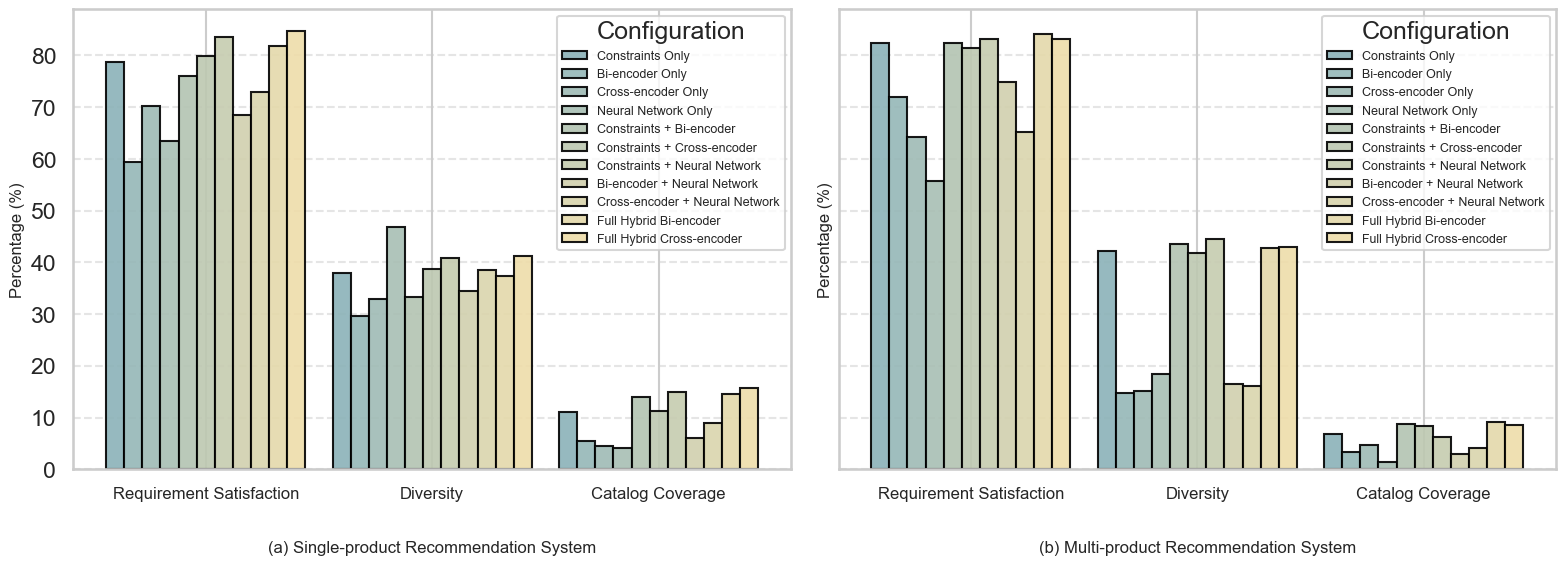

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_grouped_bar(ax, df, title, subtitle):
    melted = df.melt(
        id_vars='configuration',
        value_vars=['requirement_satisfaction', 'diversity', 'catalog_coverage'],
        var_name='Metric',
        value_name='Value'
    )

    metrics = ['requirement_satisfaction', 'diversity', 'catalog_coverage']
    configs = df['configuration'].tolist()
    num_metrics = len(metrics)
    num_configs = len(configs)

    bar_width = 0.08
    x = np.arange(num_metrics)
    palette = sns.color_palette("blend:#7AB,#EDA", n_colors=num_configs + 2)[2:]

    for i, config in enumerate(configs):
        subset = melted[melted['configuration'] == config]
        ax.bar(
            x + i * bar_width,
            subset['Value'],
            width=bar_width,
            label=config,
            color=palette[i],
            edgecolor='black',
            alpha=0.9
        )

    ax.set_xticks(x + bar_width * (num_configs - 1) / 2)
    ax.set_xticklabels(['Requirement Satisfaction', 'Diversity', 'Catalog Coverage'], fontsize=12)
    ax.set_ylabel('Percentage (%)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)

    # Subtitle below the subplot
    ax.text(0.5, -0.18, subtitle, transform=ax.transAxes, ha='center', fontsize=12)

    # Legend
    ax.legend(loc='upper right', fontsize=9, title='Configuration', framealpha=0.8)

sns.set(style="whitegrid", context="talk")
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

plot_grouped_bar(axes[0], single_df, '', '(a) Single-product Recommendation System')
plot_grouped_bar(axes[1], routine_df, '', '(b) Multi-product Recommendation System')

plt.tight_layout()
plt.show()


Based on the results of the experiments above, the key findings are as follows:
1. **The baseline configuration reveals the significant importance of constraint filtering**, achieving requirement satisfaction of 78.72% and 82.45%, in both scenarios. This component work effectively as a result of comprehensive data preparation and feature engineering that ensures each product is easy to find.
2. **The cross encoder performs better for single-product recommendations, while both methods show similar performance for multi-product**. This indicates the advantage of the cross-encoder in capturing user-relation that benefit single-product requiring more precision, while the bi-encoder is more suitable for routines, as the recommendations are distributes across multiple products.
3. **The three-stage system delivers the best results with the most optimal and balanced performance across all three metrics**. This further demonstrates the three-stage recommendation system’s effectiveness and ability to leverage the advantages of different components to enhance the overall model performance while maintaining reasonable computational time. 

# 7. Output for Real Use Case Implementation

In this section, we provide sample outputs to demonstrate how the model can be adopted for actual implementation in potential real-world use cases in the skincare industry. The recommendation system generates a list of the top five products or skincare routines, including product images and details, to help customers easily find and select the products.

In [ ]:
import matplotlib.pyplot as plt
import math
import numpy as np
import requests
from bs4 import BeautifulSoup
from PIL import Image
from io import BytesIO

### Scrape product image from Chemist Warehouse product page    
def fetch_image_from_product_page(product_url):
    
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8",
        "Accept-Language": "en-US,en;q=0.5",
        "Referer": "https://www.chemistwarehouse.com.au"
    }
    
    try:
        # Get the product page
        response = requests.get(product_url, headers=headers, timeout=10)
        
        if response.status_code != 200:
            return None
        
        # Parse HTML
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Try multiple selectors
        image_url = None
        
        img_tag = soup.find('img', {'class': 'product-image'})
        if img_tag and img_tag.get('src'):
            image_url = img_tag['src']
        
        if not image_url:
            og_image = soup.find('meta', property='og:image')
            if og_image and og_image.get('content'):
                image_url = og_image['content']

        if not image_url:
            img_tag = soup.find('img', {'itemprop': 'image'})
            if img_tag and img_tag.get('src'):
                image_url = img_tag['src']
        
        if not image_url:
            img_tag = soup.find('img', {'data-zoom-image': True})
            if img_tag:
                image_url = img_tag.get('data-zoom-image') or img_tag.get('src')
        
        if not image_url:
            return None
        
        if image_url.startswith('//'):
            image_url = 'https:' + image_url
        elif image_url.startswith('/'):
            image_url = 'https://www.chemistwarehouse.com.au' + image_url
        
        # Fetch the actual image
        img_response = requests.get(image_url, headers=headers, timeout=10)
        if img_response.status_code == 200:
            img = Image.open(BytesIO(img_response.content))
            return img
        
        return None
        
    except Exception as e:
        return None

### Create matplotlib grid fetching images from product URLs
def display_product_grid_from_urls(rec_list, product_df, images_per_row=5):

    n_products = len(rec_list)
    n_rows = math.ceil(n_products / images_per_row)
    
    fig, axes = plt.subplots(n_rows, images_per_row, 
                             figsize=(images_per_row*4.5, n_rows*6))
    
    # Handle different array shapes
    if n_products == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    
    axes_flat = axes.flatten()
    
    for idx, rec in enumerate(rec_list):
        ax = axes_flat[idx]
        
        product_name = rec['name']
        
        # Find product in DataFrame
        product_match = product_df[product_df['name'] == product_name]
        
        # Get product URL
        product_url = product_match.iloc[0]['url']
        
        if pd.isna(product_url):
            ax.text(0.5, 0.5, 'No URL', 
                   ha='center', va='center', fontsize=10, color='gray')
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.set_facecolor('#f0f0f0')
            ax.axis('off')
        else:
            # Fetch image from product page
            img = fetch_image_from_product_page(product_url)
            
            if img:
                ax.imshow(img)
                img_height, img_width = img.size[1], img.size[0]
            
                # Build product details
                details = (f"{product_name}\n"
                        f"{rec['product_type'].title()}\n"
                        f"${rec['price']:.2f}  |  ★ {rec['rating']:.1f} ({rec['reviews_count']} reviews)")
                
                ax.text(img_width / 2, img_height + 60,
                        details,
                        ha='center', va='top',
                        fontsize=9,
                        linespacing=1.5,
                        fontweight='medium',
                        color='#333',
                        bbox=dict(boxstyle='round,pad=0.8',
                                facecolor='whitesmoke',
                                edgecolor='lightgray',
                                linewidth=0.8,
                                alpha=0.9))

                # Set axis limits to include text area
                ax.set_xlim(0, img_width)
                ax.set_ylim(img_height + 200, 0)

            else:
                ax.text(0.5, 0.5, 'No Image', 
                       ha='center', va='center', fontsize=10, color='gray')
                ax.set_xlim(0, 1)
                ax.set_ylim(0, 1)
                ax.set_facecolor('#f0f0f0')
        ax.axis('off')
        
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(1.5)
            spine.set_edgecolor('#ddd')
    
    # Hide unused subplots
    for idx in range(n_products, len(axes_flat)):
        axes_flat[idx].axis('off')
    
    plt.subplots_adjust(hspace=0.6, wspace=0.35) 
    plt.show()

### Display recommendations with images scraped from product pages
def display_recommendations_with_images(all_recommendations, product_df, images_per_row=5):
    
    for i, (profile, rec_list) in enumerate(all_recommendations):
        print(f"User Profile:")
        for key, value in profile.items():
            print(f"  {key}: {value}")
        
        if not rec_list:
            continue
        
        # Check if routine or single products
        is_routine = 'routine_id' in rec_list[0]
        
        if is_routine:
            routines = {}
            for rec in rec_list:
                rid = rec['routine_id']
                if rid not in routines:
                    routines[rid] = []
                routines[rid].append(rec)
            
            for routine_id, products in routines.items():
                print(f"Routine {routine_id}")
                print(f"Total Price: ${products[0]['total_price']:.2f}")
                display_product_grid_from_urls(products, product_df, images_per_row)
        else:
            display_product_grid_from_urls(rec_list, product_df, images_per_row)

Device: mps
Training neural network using 1000 products


Generating recommedations for users: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


User Profile:
  skin_type: sensitive
  skin_problems: acne, dull skin
  allergies: impaired skin barrier
  preferred_formulation: other
  budget: 60
  product_types: [np.str_('moisturizer')]


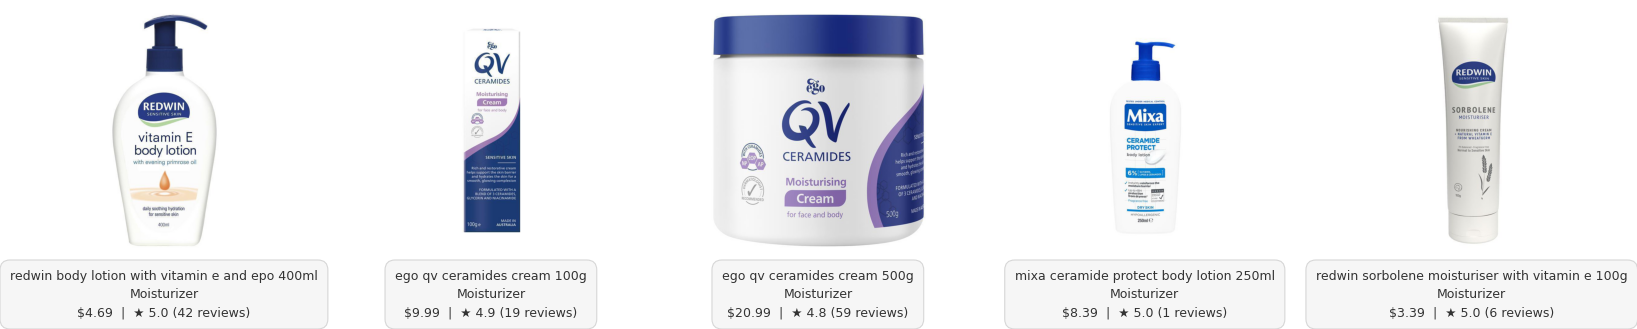

In [19]:
hybrid_system, all_recommendations = run_hybrid_recommendations(
            product_df=clean_product_df,
            user_profiles=synthetic_single[-2:-1],
            constraint_filter=True,
            cross_encoder=True,
            semantic_similarity=True,
            train_neural_network=True,
            print_result=False
        )

display_recommendations_with_images(all_recommendations, clean_product_df)
        

Device: mps
Training neural network using 999 products


Generating recommedations for users: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


User Profile:
  skin_type: dry
  skin_problems: pores
  allergies: impaired skin barrier, pregnancy
  preferred_formulation: cream
  budget: 60
  product_types: [np.str_('serum')]


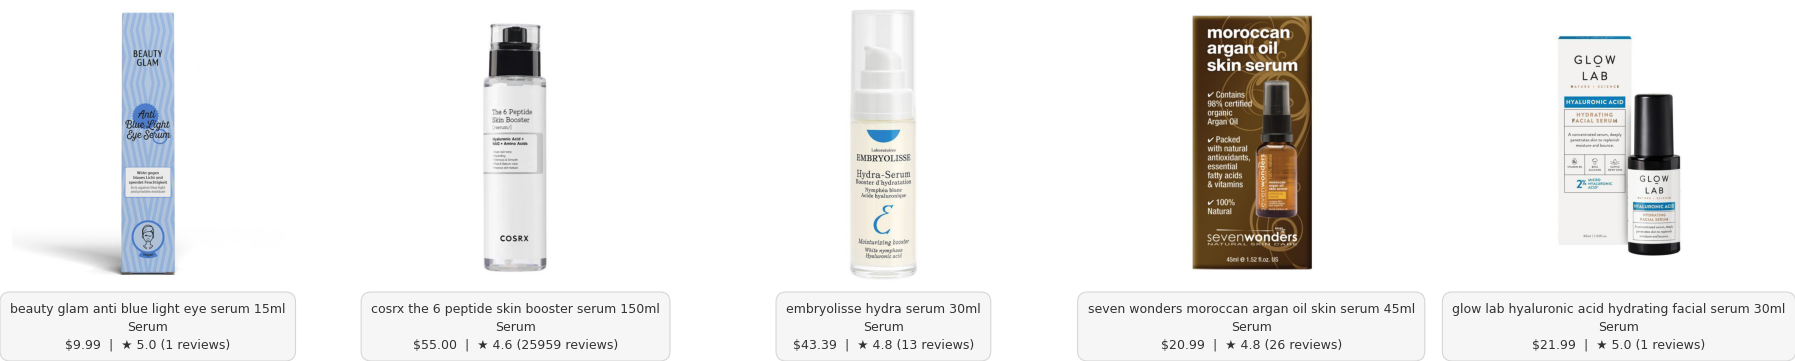

In [101]:
hybrid_system, all_recommendations = run_hybrid_recommendations(
            product_df=clean_product_df,
            user_profiles=synthetic_single[19:20],
            constraint_filter=True,
            cross_encoder=True,
            semantic_similarity=True,
            train_neural_network=True,
            print_result=False
        )

display_recommendations_with_images(all_recommendations, clean_product_df)
        

Device: mps
Training neural network using 1000 products


Generating recommedations for users: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it]


User Profile:
  skin_type: dry
  skin_problems: impaired skin barrier
  allergies: pregnancy, impaired skin barrier
  preferred_formulation: cream
  budget: 75
  product_types: ['cleanser', 'toner', 'serum', 'moisturizer', 'sunscreen']
Routine 1
Total Price: $73.35


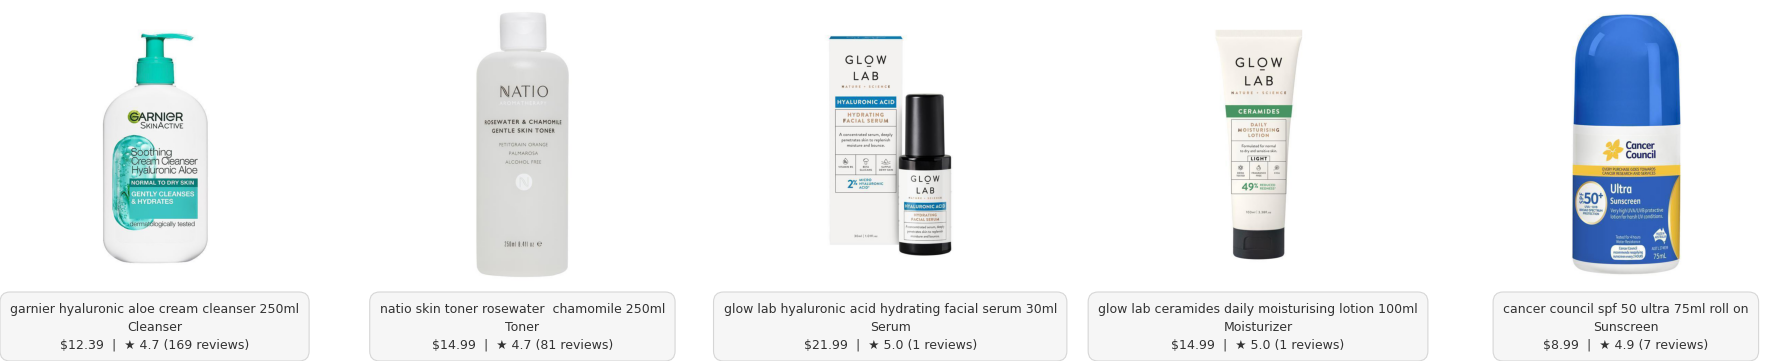

Routine 2
Total Price: $74.05


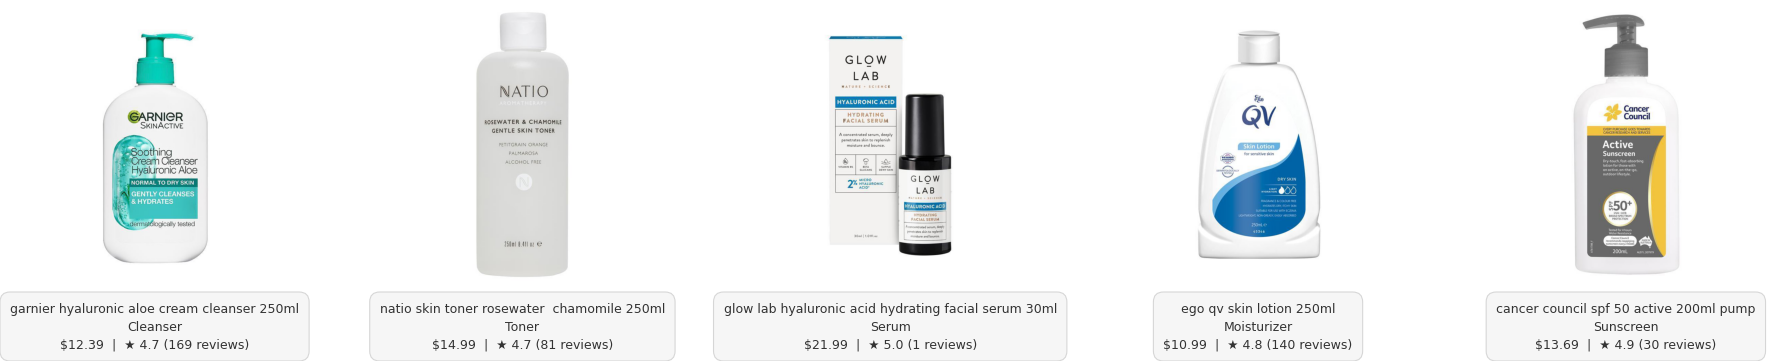

Routine 3
Total Price: $72.05


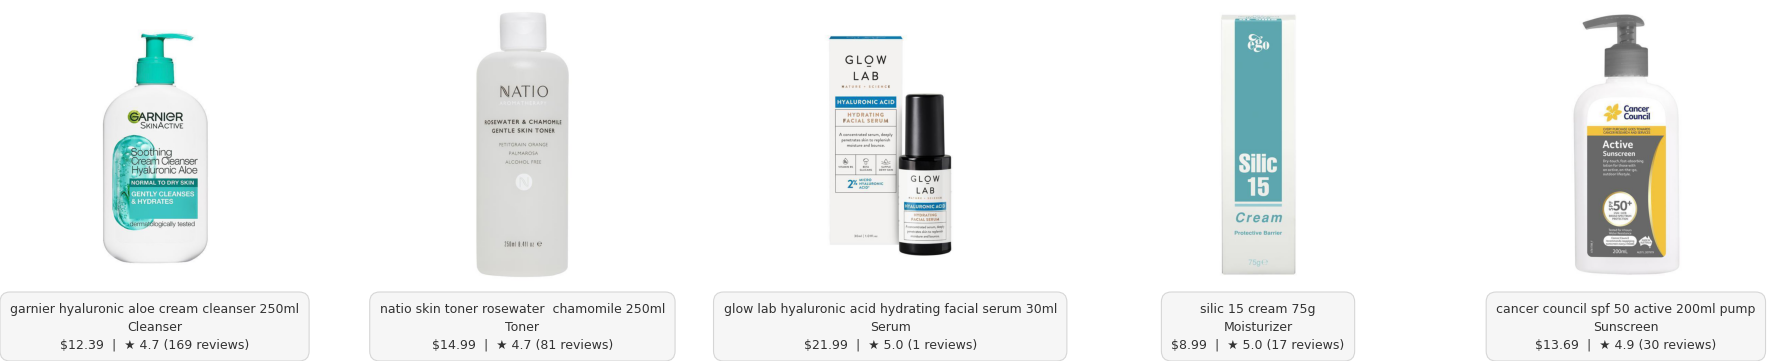

Routine 4
Total Price: $69.35


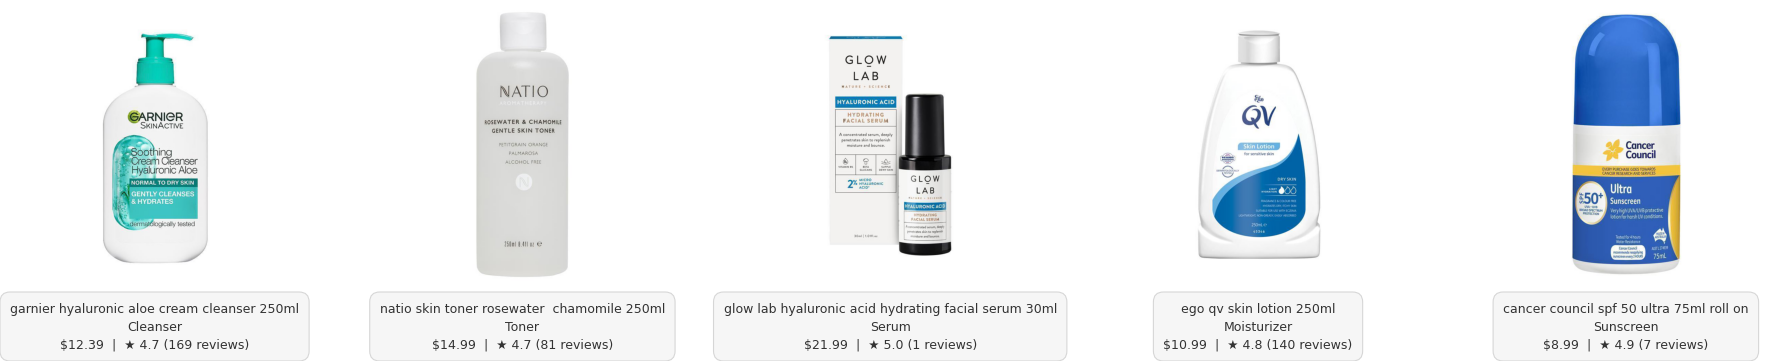

Routine 5
Total Price: $67.35


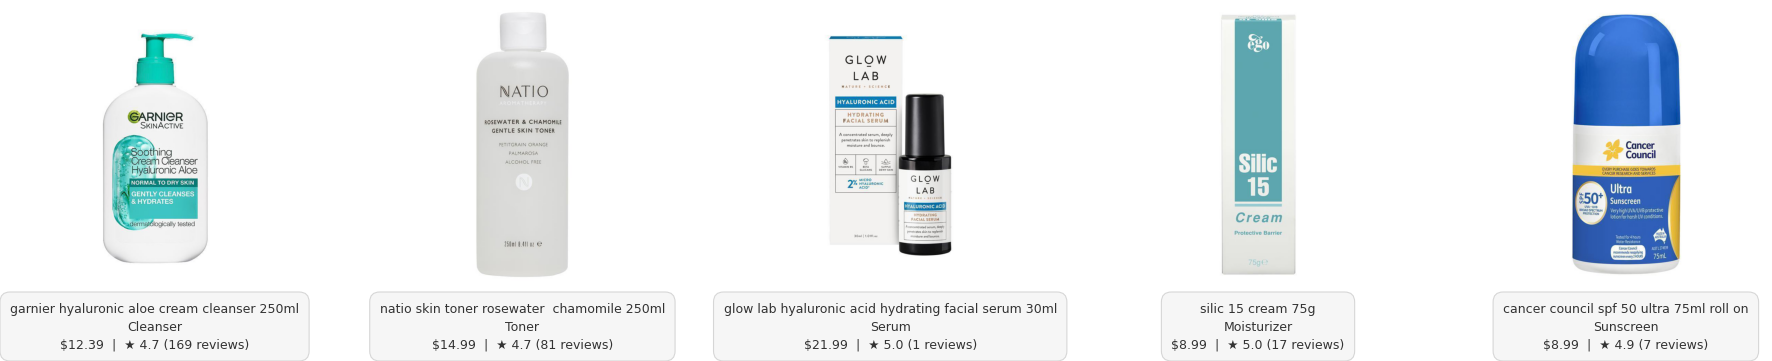

In [55]:
hybrid_system, all_recommendations = run_hybrid_recommendations(
            product_df=clean_product_df,
            user_profiles=synthetic_routine[10:11],
            constraint_filter=True,
            cross_encoder=True,
            semantic_similarity=True,
            train_neural_network=True,
            print_result=False
        )

display_recommendations_with_images(all_recommendations, clean_product_df)
        